# Ray Tracing in One Weekend (Python V_4.0)
    Peter Shirley, Trevor David Black, Steve Hollasch
    Version 4.0.0-alpha.1, 2023-08-06
    Copyright 2018-2023 Peter Shirley. All rights reserved.

In [1]:
import time
def timing(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"{func.__name__} took {elapsed_time:.4f} seconds to execute.")
        return result

    return wrapper

## 2. Output an Image

    1) 定义图片大小 image_array: [image_height, image_width]
    2) 双层遍历图片高宽, 设置每个像素点的颜色
    3) 循环结束后将python二维矩阵转为np.uint8后，使用pillow库展示并输出
    4) 使用tqdm和上文定义的装饰器timing 来计时

    备注:
    * (r, g, b)颜色范围为[0,1]，(ir, ig, ib)转为[0, 255] uint8格式(共256位)

100%|██████████| 256/256 [00:00<00:00, 6060.65it/s]


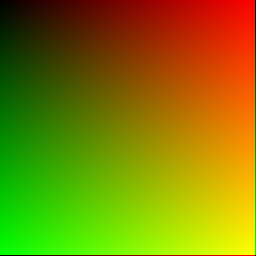

main took 0.0891 seconds to execute.


In [2]:
from tqdm import tqdm
import numpy as np
from PIL import Image

@timing
def main():
    # Image
    image_width = 256
    image_height = 256

    # Render
    image_array = []

    for j in tqdm(range(image_height)):
        image_rows = []
        for i in range(image_width):
            r = float(i) / image_width-1
            g = float(j) / image_height-1
            b = 0

            ir = int(255.999 * r)
            ig = int(255.999 * g)
            ib = int(255.999 * b)
            image_rows.append((ir,ig,ib))
        image_array.append(image_rows)
    
    im = Image.fromarray(np.uint8(image_array))
    im.show()
    im.save("render.png", "PNG")

main()

## 3. The vec3 Class

In [3]:
from typing import TypeAlias
class Vec3:
    def __init__(self, e0=0, e1=0, e2=0):
        self.e = [float(x) for x in [e0, e1, e2]]

    @property
    def x(self): return self.e[0]
    @property
    def y(self): return self.e[1]
    @property
    def z(self): return self.e[2]
    
    ########################
    # Vec3直接索引
    def __getitem__(self, key):
        return self.e[key]

    def __setitem__(self, key, value):
        self.e[key] = value

    ########################
    # 取值、输出
    def to_tuple(self):
        return tuple(self.e)
    
    def __str__(self):
        return " Vec3 : " + str(tuple(self.e))

    ########################
    # 运算符重载
    def __neg__(self):
        return Vec3(*[-x for x in self.e])
    
    def __add__(self, other):
        if isinstance(other, Vec3):
            return Vec3(*[self[i] + other[i] for i in range(3)])  # vector add
        elif isinstance(other, (int, float)):
            return Vec3(*[self[i] + other for i in range(3)])  # scalar add
        else:
            return NotImplemented  # 表示不支持的类型

    def __radd__(self, other):
        # 当整数在左侧时，调用 __radd__
        return self.__add__(other)

    def __sub__(self, other):
        if isinstance(other, Vec3):
            return Vec3(*[self[i] - other[i] for i in range(3)])
        elif isinstance(other, (int, float)):
            return Vec3(*[self[i] - other for i in range(3)])
        else:
            return NotImplemented  # 表示不支持的类型

    def __mul__(self, other):
        if isinstance(other, Vec3):
            return Vec3(*[self[i] * other[i] for i in range(3)])
        elif isinstance(other, (int, float)):
            return Vec3(*[self[i] * other for i in range(3)])
        else:
            return NotImplemented  # 表示不支持的类型

    def __rmul__(self, other):
        # 当整数在左侧时，调用 __rmul__
        return self.__mul__(other)

    def __truediv__(self, other):
        if isinstance(other, Vec3):
            if other[0] != 0 and other[1] != 0 and other[2] != 0:
                return Vec3(*[self[i] / other[i] for i in range(3)])
            else:
                raise ValueError("Division by vector having zero items")
        elif isinstance(other, (int, float)):
            if other != 0:
                return Vec3(*[self[i] / other for i in range(3)])
            else:
                raise ValueError("Division by zero")
        else:
            return NotImplemented  # 表示不支持的类型

    def __eq__(self, other) -> bool:
        if isinstance(other, Vec3):
            return abs((self - other).length() - 0) < 1e-8
            # return all([self[i] == other[i] for i in range(3)])
        else:
            return False  # 表示不支持的类型
    
    def length(self):
        return np.sqrt(self.length_squared())
     
    def length_squared(self):
        return self.x ** 2 + self.y ** 2 + self.z ** 2


def dot(u:'Vec3', v:'Vec3') -> 'Vec3':
    return sum(u * v)

# 右手定则
def cross(u:'Vec3', v: 'Vec3') -> 'Vec3':
    return Vec3(*[
        u[1] * v[2] - u[2] * v[1],
        u[2] * v[0] - u[0] * v[2],
        u[0] * v[1] - u[1] * v[0]])

def unit_vector(v:'Vec3') -> 'Vec3':
    return v / v.length()

Color: TypeAlias = Vec3
Point3: TypeAlias = Vec3

In [4]:
def write_color(pixel_color: Color):
    # Write the translated [0,255] value of each color component.
    return Color(*[int(255.999 * pixel_color[i]) for i in range(3)])

100%|██████████| 256/256 [00:00<00:00, 1537.17it/s]


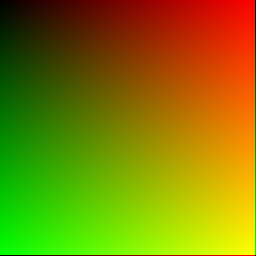

main took 0.2014 seconds to execute.


In [5]:
@timing
def main():
    # Image
    image_width = 256
    image_height = 256

    # Render
    image_array = []

    for j in tqdm(range(image_height)):
        image_rows = []
        for i in range(image_width):
            pixel_color = Color(float(i) / image_width-1, 
                                float(j) / image_height-1,
                                0)
            image_color:Color =  write_color(pixel_color)

            image_rows.append(image_color.to_tuple())
        image_array.append(image_rows)
    
    im = Image.fromarray(np.uint8(image_array))
    im.show()
    im.save("render.png", "PNG")

main()

## 4. Rays, a Simple Camera, and Background

In [6]:
class Ray:
    def __init__(self, ori, dire):
        self.ori = ori
        self.dire = dire

    def origin(self):
        return self.ori

    def direction(self):
        return self.dire

    def at(self, t):
        return self.ori + t * self.dire


100%|██████████| 225/225 [00:01<00:00, 216.78it/s]


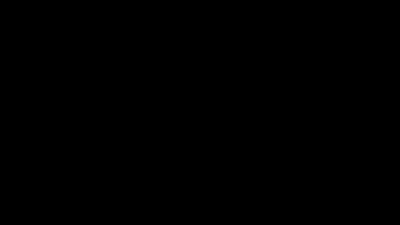

main took 1.0784 seconds to execute.


In [7]:
def ray_color(r:Ray) -> Color:
    return Color(0, 0, 0)

@timing
def main():
    # Image

    aspect_ratio = 16.0 / 9.0
    image_width = 400

    # Calculate the image height, and ensure that it's at least 1.
    image_height = int(image_width / aspect_ratio)
    image_height = 1 if (image_height < 1) else image_height

    # Camera
    focal_length = 1.0
    viewport_height = 2.0
    viewport_width = viewport_height * (float(image_width)/image_height)
    camera_center = Point3(0, 0, 0)

    # Calculate the vectors across the horizontal and down the vertical viewport edges.
    viewport_u = Vec3(viewport_width, 0, 0)
    viewport_v = Vec3(0, -viewport_height, 0)

    # Calculate the horizontal and vertical delta vectors from pixel to pixel.
    pixel_delta_u = viewport_u / image_width
    pixel_delta_v = viewport_v / image_height

    # Calculate the location of the upper left pixel.
    viewport_upper_left = camera_center - Vec3(0, 0, focal_length) - viewport_u/2 - viewport_v/2
    pixel00_loc = viewport_upper_left + 0.5 * (pixel_delta_u + pixel_delta_v)

    # Render
    image_array = []

    for j in tqdm(range(image_height)):
        image_rows = []
        for i in range(image_width):
            pixel_center = pixel00_loc + (i * pixel_delta_u) + (j * pixel_delta_v)
            ray_direction = pixel_center - camera_center
            r:Ray = Ray(camera_center, ray_direction)
            pixel_color = ray_color(r)

            image_rows.append(write_color(pixel_color).to_tuple())
        image_array.append(image_rows)
    
    im = Image.fromarray(np.uint8(image_array))
    im.show()
    im.save("render.png", "PNG")

main()

100%|██████████| 225/225 [00:01<00:00, 112.72it/s]


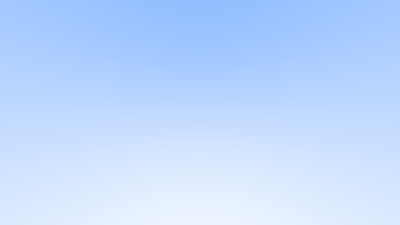

main took 2.0426 seconds to execute.


In [8]:
# 插值产生蓝天过度色
def ray_color(r:Ray) -> Color:
    unit_direction:Vec3 = unit_vector(r.direction())
    a = 0.5*(unit_direction.y + 1.0)
    return (1.0-a)*Color(1.0, 1.0, 1.0) + a*Color(0.5, 0.7, 1.0)
main()

## 5. Adding a Sphere

100%|██████████| 225/225 [00:02<00:00, 80.61it/s]


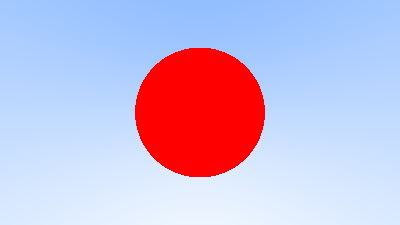

main took 2.8384 seconds to execute.


In [9]:
def hit_sphere(center:Point3, radius:float, r:Ray):
    oc:Vec3 = r.origin() - center
    a = dot(r.direction(), r.direction())
    b = 2.0 * dot(oc, r.direction())
    c = dot(oc, oc) - radius*radius
    discriminant = b*b - 4*a*c
    return discriminant >= 0

def ray_color(r:Ray) -> Color:
    if hit_sphere(Point3(0,0,-1), 0.5, r):
        return Color(1, 0, 0)
    
    unit_direction:Vec3 = unit_vector(r.direction())
    a = 0.5*(unit_direction.y + 1.0)
    return (1.0-a)*Color(1.0, 1.0, 1.0) + a*Color(0.5, 0.7, 1.0)

main()

## 6. Surface Normals and Multiple Objects

### 6.1 Shading with Surface Normals

100%|██████████| 225/225 [00:03<00:00, 70.35it/s]


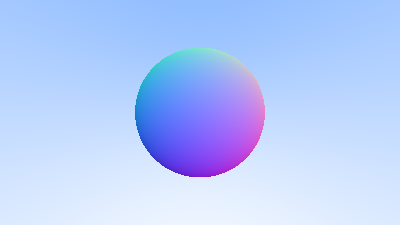

main took 3.2517 seconds to execute.


In [10]:
def hit_sphere(center:Point3, radius:float, r:Ray):
    oc:Vec3 = r.origin() - center
    a = dot(r.direction(), r.direction())
    b = 2.0 * dot(oc, r.direction())
    c = dot(oc, oc) - radius*radius
    discriminant = b*b - 4*a*c
    
    if discriminant < 0:
        return -1.0
    else:
        return (-b - np.sqrt(discriminant) ) / (2.0*a)

def ray_color(r:Ray) -> Color:
    t = hit_sphere(Point3(0,0,-1), 0.5, r)
    if t > 0.0:
        N:Vec3 = unit_vector(r.at(t) - Vec3(0,0,-1))
        return 0.5 * Color(N.x+1, N.y+1, N.z+1)
    
    unit_direction:Vec3 = unit_vector(r.direction())
    a = 0.5*(unit_direction.y + 1.0)
    return (1.0-a)*Color(1.0, 1.0, 1.0) + a*Color(0.5, 0.7, 1.0)

main()

### 6.2 Simplifying the Ray-Sphere Intersection Code

100%|██████████| 225/225 [00:02<00:00, 83.42it/s]


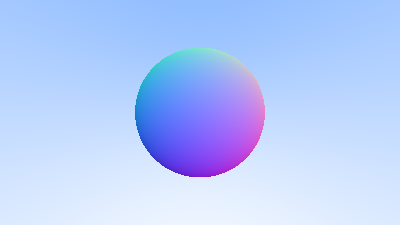

main took 2.7492 seconds to execute.


In [11]:
def hit_sphere(center:Point3, radius:float, r:Ray):
    oc:Vec3 = r.origin() - center
    a = r.direction().length_squared()
    half_b = dot(oc, r.direction())
    c = oc.length_squared() - radius*radius
    discriminant = half_b*half_b - a*c

    if discriminant < 0:
        return -1.0
    else:
        return (-half_b - np.sqrt(discriminant) ) / a

main()

### 6.3 An Abstraction for Hittable Objects
### 6.4 Front Faces Versus Back Faces

In [12]:
from typing import Tuple, Optional

# 记录ray碰撞结果
class HitRecord:
    def __init__(self, p, t) -> None:
        self.p = p
        self.t = t

    def set_face_normal(self, ray, outward_normal):
        # Sets the hit record normal vector.
        # NOTE: the parameter `outward_normal` is assumed to have unit length.

        # 视角是否在物体内部
        self.front_face = dot(ray.direction(), outward_normal) < 0  # 向量逆向，dot值为负数 
        self.normal = outward_normal if self.front_face else -outward_normal

# 抽象基类
class Hittable:
    def hit(self, ray:Ray, ray_tmin:float, ray_tmax:float) -> Tuple[bool, Optional[HitRecord]]:
        pass

In [13]:
class Sphere(Hittable):
    def __init__(self, center, radius):
        self.center: Point3 = center
        self.radius: float = radius

    def hit(self, ray:Ray, ray_tmin:float, ray_tmax:float) -> Tuple[bool, Optional[HitRecord]]:
        oc: Vec3 = ray.origin() - self.center  # A-C
        a = ray.direction().length_squared()  # b*b
        half_b = dot(oc, ray.direction())  # b*(A-C)
        c = oc.length_squared() - self.radius * self.radius  # (A-C)*(A-C) - r*r

        discriminant = half_b * half_b - a * c  # 二次方程解的判定条件
        if discriminant < 0: return (False, None)
        sqrtd = np.sqrt(discriminant)

        # // Find the nearest root that lies in the acceptable range.
        root = (-half_b - sqrtd) / a
        if root <= ray_tmin or ray_tmax <= root:
            root = (-half_b + sqrtd) / a
            if root <= ray_tmin or ray_tmax <= root:
                return (False, None)

        # 存在合理碰撞，记录碰撞点
        t = root
        p = ray.at(t)
        hit_record = HitRecord(t=t, p=p)
        
        # 判定ray在物体内外，并设置相逆的normal
        outward_normal = (p - self.center) / self.radius
        hit_record.set_face_normal(ray=ray, outward_normal=outward_normal)

        return (True, hit_record)


### 6.5 A List of Hittable Objects

In [14]:
class HittableList(Hittable):
    def __init__(self):
        self.objects = []

    def add(self, obj: Hittable):
        self.objects.append(obj)

    def hit(self, ray:Ray, ray_tmin:float, ray_tmax:float) -> Tuple[bool, Optional[HitRecord]]:
        res_rec = None  # 当前hit调用需要返回的最终结果
        hit_anything = False
        closest_so_far = ray_tmax

        # 遍历需要render的对象
        for obj in self.objects:
            hit, rec = obj.hit(ray, ray_tmin, closest_so_far)
            if hit:
                hit_anything = True
                closest_so_far = rec.t
                res_rec = rec

        if hit_anything:
            return (True, res_rec)

        return (False, None)

### 6.7 Common Constants and Utility Functions

In [15]:
INF = float('inf')  # 正无穷大
PI = 3.1415926535897932385

def degrees_to_radians(degrees):
    return degrees * PI / 180.0

100%|██████████| 225/225 [00:03<00:00, 57.17it/s]


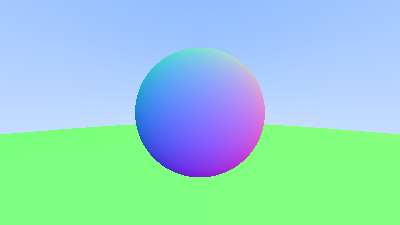

main took 3.9849 seconds to execute.


In [16]:
def ray_color(r:Ray, world:Hittable) -> Color:
    hit, rec = world.hit(r, 0, INF)
    if hit:
        return 0.5 * (rec.normal + Color(1,1,1))
    
    unit_direction:Vec3 = unit_vector(r.direction())
    a = 0.5*(unit_direction.y + 1.0)
    return (1.0-a)*Color(1.0, 1.0, 1.0) + a*Color(0.5, 0.7, 1.0)

@timing
def main():
    # Image

    aspect_ratio = 16.0 / 9.0
    image_width = 400

    # Calculate the image height, and ensure that it's at least 1.
    image_height = int(image_width / aspect_ratio)
    image_height = 1 if (image_height < 1) else image_height
    
    # World
    world = HittableList()

    world.add(Sphere(Point3(0,0,-1), 0.5))
    world.add(Sphere(Point3(0,-100.5,-1), 100))
    

    # Camera
    focal_length = 1.0
    viewport_height = 2.0
    viewport_width = viewport_height * (float(image_width)/image_height)
    camera_center = Point3(0, 0, 0)

    # Calculate the vectors across the horizontal and down the vertical viewport edges.
    viewport_u = Vec3(viewport_width, 0, 0)
    viewport_v = Vec3(0, -viewport_height, 0)

    # Calculate the horizontal and vertical delta vectors from pixel to pixel.
    pixel_delta_u = viewport_u / image_width
    pixel_delta_v = viewport_v / image_height

    # Calculate the location of the upper left pixel.
    viewport_upper_left = camera_center - Vec3(0, 0, focal_length) - viewport_u/2 - viewport_v/2
    pixel00_loc = viewport_upper_left + 0.5 * (pixel_delta_u + pixel_delta_v)

    # Render
    image_array = []

    for j in tqdm(range(image_height)):
        image_rows = []
        for i in range(image_width):
            pixel_center = pixel00_loc + (i * pixel_delta_u) + (j * pixel_delta_v)
            ray_direction = pixel_center - camera_center
            r:Ray = Ray(camera_center, ray_direction)
            pixel_color = ray_color(r, world)

            image_rows.append(write_color(pixel_color).to_tuple())
        image_array.append(image_rows)
    
    im = Image.fromarray(np.uint8(image_array))
    im.show()
    im.save("render.png", "PNG")

main()

### 6.8 An Interval Class

In [17]:
class Interval:
    def __init__(self, _min=INF, _max=-INF):  # Default interval is empty
        self.min: float = _min
        self.max: float = _max

    def contains(self, x):
        return self.min <= x <= self.max

    def surrounds(self, x):
        return self.min < x < self.max

interval_empty = Interval(INF, -INF)
interval_universe = Interval(-INF, INF)

In [18]:
# 抽象基类
class Hittable:
    def hit(self, ray:Ray, ray_t:Interval) -> Tuple[bool, Optional[HitRecord]]:
        pass

In [19]:
class HittableList(Hittable):
    def __init__(self):
        self.objects = []

    def add(self, obj: Hittable):
        self.objects.append(obj)

    def hit(self, ray:Ray, ray_t:Interval) -> Tuple[bool, Optional[HitRecord]]:
        res_rec = None  # 当前hit调用需要返回的最终结果
        hit_anything = False
        closest_so_far = ray_t.max

        # 遍历需要render的对象
        for obj in self.objects:
            hit, rec = obj.hit(ray,  Interval(ray_t.min, closest_so_far))
            if hit:
                hit_anything = True
                closest_so_far = rec.t
                res_rec = rec

        if hit_anything:
            return (True, res_rec)

        return (False, None)

In [20]:
class Sphere(Hittable):
    def __init__(self, center, radius):
        self.center: Point3 = center
        self.radius: float = radius

    def hit(self, ray:Ray, ray_t:Interval) -> Tuple[bool, Optional[HitRecord]]:
        oc: Vec3 = ray.origin() - self.center  # A-C
        a = ray.direction().length_squared()  # b*b
        half_b = dot(oc, ray.direction())  # b*(A-C)
        c = oc.length_squared() - self.radius * self.radius  # (A-C)*(A-C) - r*r

        discriminant = half_b * half_b - a * c  # 二次方程解的判定条件
        if discriminant < 0: return (False, None)
        sqrtd = np.sqrt(discriminant)

        # // Find the nearest root that lies in the acceptable range.
        root = (-half_b - sqrtd) / a
        if not ray_t.surrounds(root):  # root <= ray_t.min or ray_t.max <= root
            root = (-half_b + sqrtd) / a  # 候选较大值
            if not ray_t.surrounds(root):
                return (False, None)

        # 存在合理碰撞，记录碰撞点
        t = root
        p = ray.at(t)
        hit_record = HitRecord(t=t, p=p)
        
        # 判定ray在物体内外，并设置相逆的normal
        outward_normal = (p - self.center) / self.radius
        hit_record.set_face_normal(ray=ray, outward_normal=outward_normal)

        return (True, hit_record)

100%|██████████| 225/225 [00:03<00:00, 56.82it/s]


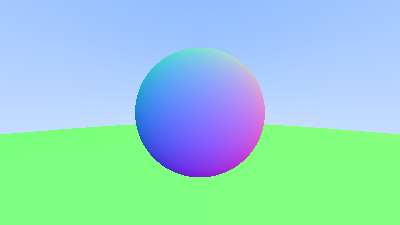

main took 4.0085 seconds to execute.


In [21]:
def ray_color(r:Ray, world:Hittable) -> Color:
    hit, rec = world.hit(r, Interval(0, INF))
    if hit:
        return 0.5 * (rec.normal + Color(1,1,1))
    
    unit_direction:Vec3 = unit_vector(r.direction())
    a = 0.5*(unit_direction.y + 1.0)
    return (1.0-a)*Color(1.0, 1.0, 1.0) + a*Color(0.5, 0.7, 1.0)

main()

## 7. Moving Camera Code Into Its Own Class

In [22]:
class Camera:
    def __init__(self,
                 aspect_ratio=1.0,
                 image_width=100,
                 ) -> None:

        # public
        self.aspect_ratio = aspect_ratio  # Ratio of image width over height
        self.image_width = image_width  # Rendered image width in pixel count
        
    def render(self, world:HittableList):
        self.initialize()
        
        image_array = []

        for j in tqdm(range(self.image_height)):
            image_rows = []
            for i in range(self.image_width):
                pixel_center = self.pixel00_loc + (i * self.pixel_delta_u) + (j * self.pixel_delta_v)
                ray_direction = pixel_center - self.camera_center
                r:Ray = Ray(self.camera_center, ray_direction)
                pixel_color = ray_color(r, world)

                image_rows.append(write_color(pixel_color).to_tuple())
            image_array.append(image_rows)
        
        im = Image.fromarray(np.uint8(image_array))
        im.show()
        im.save("render.png", "PNG")
        

    def initialize(self):
        self.image_height = int(self.image_width / self.aspect_ratio)
        self.image_height = 1 if (self.image_height < 1) else self.image_height
        
        self.camera_center = Point3(0, 0, 0)

        # Camera
        focal_length = 1.0
        viewport_height = 2.0
        viewport_width = viewport_height * (float(self.image_width)/self.image_height)
        self.camera_center = Point3(0, 0, 0)

        # Calculate the vectors across the horizontal and down the vertical viewport edges.
        viewport_u = Vec3(viewport_width, 0, 0)
        viewport_v = Vec3(0, -viewport_height, 0)

        # Calculate the horizontal and vertical delta vectors from pixel to pixel.
        self.pixel_delta_u = viewport_u / self.image_width
        self.pixel_delta_v = viewport_v / self.image_height

        # Calculate the location of the upper left pixel.
        viewport_upper_left = self.camera_center - Vec3(0, 0, focal_length) - viewport_u/2 - viewport_v/2
        self.pixel00_loc = viewport_upper_left + 0.5 * (self.pixel_delta_u + self.pixel_delta_v)


    def ray_color(self, r: Ray, world: Hittable) -> Color:
        hit, rec = world.hit(r, Interval(0, INF))
        if hit:
            return 0.5 * (rec.normal + Color(1,1,1))
        
        unit_direction:Vec3 = unit_vector(r.direction())
        a = 0.5*(unit_direction.y + 1.0)
        return (1.0-a)*Color(1.0, 1.0, 1.0) + a*Color(0.5, 0.7, 1.0)

100%|██████████| 225/225 [00:04<00:00, 55.65it/s]


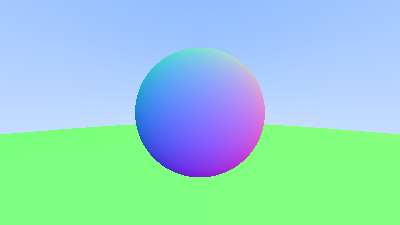

main took 4.0943 seconds to execute.


In [23]:
@timing
def main():
    # World
    world = HittableList()

    world.add(Sphere(Point3(0,0,-1), 0.5))
    world.add(Sphere(Point3(0,-100.5,-1), 100))

    aspect_ratio = 16.0 / 9.0
    image_width = 400
    cam = Camera(aspect_ratio=aspect_ratio,
                 image_width=image_width)

    cam.render(world=world)
    
main()

## 8. Antialiasing

### 8.1. Some Random Number Utilities

In [24]:
import random
def my_random(_min=0, _max=1):
    # Returns a random real in [min,max).
    return _min + (_max - _min) * random.random()

### 8.2. Generating Pixels with Multiple Samples

In [25]:
class Interval:
    def __init__(self, _min=INF, _max=-INF):  # Default interval is empty

        self.min: float = _min
        self.max: float = _max

    def contains(self, x):
        return self.min <= x <= self.max

    def surrounds(self, x):
        return self.min < x < self.max

    def clamp(self, x):
        if x < self.min: return self.min
        if x > self.max: return self.max
        return x


interval_empty = Interval(INF, -INF)
interval_universe = Interval(-INF, INF)

In [26]:
def intensity():
    return Interval(_min=0.000, _max=0.999)

def write_color(pixel_color: Color, samples_per_pixel: int):
    scale = 1.0 / samples_per_pixel
    return Color(*[int(256 * intensity().clamp(1.0*pixel_color[i] * scale)) for i in range(3)])

In [27]:
class Camera:
    def __init__(self,
                 aspect_ratio=1.0,
                 image_width=100,
                 samples_per_pixel = 10,
                 ) -> None:

        # public
        self.aspect_ratio = aspect_ratio  # Ratio of image width over height
        self.image_width = image_width  # Rendered image width in pixel count
        self.samples_per_pixel = samples_per_pixel   # Count of random samples for each pixel
        
    def render(self, world:HittableList):
        self.initialize()
        
        image_array = []

        for j in tqdm(range(self.image_height)):
            image_rows = []
            for i in range(self.image_width):
                pixel_color = Color(0,0,0)
                for _ in range(self.samples_per_pixel):
                    r:Ray = self.get_ray(i, j)
                    pixel_color += self.ray_color(r, world)

                image_rows.append(write_color(pixel_color, self.samples_per_pixel).to_tuple())
            image_array.append(image_rows)
        
        im = Image.fromarray(np.uint8(image_array))
        im.show()
        im.save("render.png", "PNG")
        

    def initialize(self):
        self.image_height = int(self.image_width / self.aspect_ratio)
        self.image_height = 1 if (self.image_height < 1) else self.image_height
        
        self.camera_center = Point3(0, 0, 0)

        # Camera
        focal_length = 1.0
        viewport_height = 2.0
        viewport_width = viewport_height * (float(self.image_width)/self.image_height)
        self.camera_center = Point3(0, 0, 0)

        # Calculate the vectors across the horizontal and down the vertical viewport edges.
        viewport_u = Vec3(viewport_width, 0, 0)
        viewport_v = Vec3(0, -viewport_height, 0)

        # Calculate the horizontal and vertical delta vectors from pixel to pixel.
        self.pixel_delta_u = viewport_u / self.image_width
        self.pixel_delta_v = viewport_v / self.image_height

        # Calculate the location of the upper left pixel.
        viewport_upper_left = self.camera_center - Vec3(0, 0, focal_length) - viewport_u/2 - viewport_v/2
        self.pixel00_loc = viewport_upper_left + 0.5 * (self.pixel_delta_u + self.pixel_delta_v)


        # 采样像素(i,j)中的一条光线
    def get_ray(self, i: int, j: int) -> Ray:
        # Get a randomly sampled camera ray for the pixel at location i,j.
        pixel_center = self.pixel00_loc + (i * self.pixel_delta_u) + (j * self.pixel_delta_v)
        pixel_sample = pixel_center + self.pixel_sample_square()

        ray_origin = self.camera_center
        ray_direction = pixel_sample - ray_origin

        return Ray(ray_origin, ray_direction)

    def pixel_sample_square(self) -> Vec3:
        # Returns a random point in the square surrounding a pixel at the origin.
        px = -0.5 + my_random()  # a random real in [0,1).
        py = -0.5 + my_random()  # a random real in [0,1).
        return (px * self.pixel_delta_u) + (py * self.pixel_delta_v)
    
    def ray_color(self, r: Ray, world: Hittable) -> Color:
        hit, rec = world.hit(r, Interval(0, INF))
        if hit:
            return 0.5 * (rec.normal + Color(1,1,1))
        
        unit_direction:Vec3 = unit_vector(r.direction())
        a = 0.5*(unit_direction.y + 1.0)
        return (1.0-a)*Color(1.0, 1.0, 1.0) + a*Color(0.5, 0.7, 1.0)

100%|██████████| 168/168 [00:13<00:00, 12.65it/s]


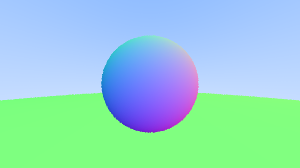

main took 13.3212 seconds to execute.


In [28]:
@timing
def main():
    # World
    world = HittableList()

    world.add(Sphere(Point3(0,0,-1), 0.5))
    world.add(Sphere(Point3(0,-100.5,-1), 100))

    aspect_ratio = 16.0 / 9.0
    image_width = 300
    samples_per_pixel = 5
    
    camera = Camera(aspect_ratio=aspect_ratio,
                 image_width=image_width,
                 samples_per_pixel=samples_per_pixel)

    camera.render(world=world)
    
main()

## 9. Diffuse Materials

In [29]:
from typing import TypeAlias
class Vec3:
    def __init__(self, e0=0, e1=0, e2=0):
        self.e = [float(x) for x in [e0, e1, e2]]

    @property
    def x(self): return self.e[0]
    @property
    def y(self): return self.e[1]
    @property
    def z(self): return self.e[2]
    
    ########################
    # Vec3直接索引
    def __getitem__(self, key):
        return self.e[key]

    def __setitem__(self, key, value):
        self.e[key] = value

    ########################
    # 取值、输出
    def to_tuple(self):
        return tuple(self.e)
    
    def __str__(self):
        return " Vec3 : " + str(tuple(self.e))

    ########################
    # 运算符重载
    def __neg__(self):
        return Vec3(*[-x for x in self.e])
    
    def __add__(self, other):
        if isinstance(other, Vec3):
            return Vec3(*[self[i] + other[i] for i in range(3)])  # vector add
        elif isinstance(other, (int, float)):
            return Vec3(*[self[i] + other for i in range(3)])  # scalar add
        else:
            return NotImplemented  # 表示不支持的类型

    def __radd__(self, other):
        # 当整数在左侧时，调用 __radd__
        return self.__add__(other)

    def __sub__(self, other):
        if isinstance(other, Vec3):
            return Vec3(*[self[i] - other[i] for i in range(3)])
        elif isinstance(other, (int, float)):
            return Vec3(*[self[i] - other for i in range(3)])
        else:
            return NotImplemented  # 表示不支持的类型

    def __mul__(self, other):
        if isinstance(other, Vec3):
            return Vec3(*[self[i] * other[i] for i in range(3)])
        elif isinstance(other, (int, float)):
            return Vec3(*[self[i] * other for i in range(3)])
        else:
            return NotImplemented  # 表示不支持的类型

    def __rmul__(self, other):
        # 当整数在左侧时，调用 __rmul__
        return self.__mul__(other)

    def __truediv__(self, other):
        if isinstance(other, Vec3):
            if other[0] != 0 and other[1] != 0 and other[2] != 0:
                return Vec3(*[self[i] / other[i] for i in range(3)])
            else:
                raise ValueError("Division by vector having zero items")
        elif isinstance(other, (int, float)):
            if other != 0:
                return Vec3(*[self[i] / other for i in range(3)])
            else:
                raise ValueError("Division by zero")
        else:
            return NotImplemented  # 表示不支持的类型

    def __eq__(self, other) -> bool:
        if isinstance(other, Vec3):
            return abs((self - other).length() - 0) < 1e-8
            # return all([self[i] == other[i] for i in range(3)])
        else:
            return False  # 表示不支持的类型
    
    def length(self):
        return np.sqrt(self.length_squared())
     
    def length_squared(self):
        return self.x ** 2 + self.y ** 2 + self.z ** 2

    @staticmethod
    def random(_min=0.0, _max=1.0):
        # 使用静态方法创建类的实例
        return Vec3(my_random(_min, _max), my_random(_min, _max), my_random(_min, _max))


def dot(u:'Vec3', v:'Vec3') -> 'Vec3':
    return sum(u * v)

# 右手定则
def cross(u:'Vec3', v: 'Vec3') -> 'Vec3':
    return Vec3(*[
        u[1] * v[2] - u[2] * v[1],
        u[2] * v[0] - u[0] * v[2],
        u[0] * v[1] - u[1] * v[0]])

def unit_vector(v:'Vec3') -> 'Vec3':
    return v / v.length()

def random_in_unit_sphere() -> Vec3:
    while True:
        p = Vec3.random(-1, 1)
        if p.length_squared() < 1:
            return p

def random_unit_vector() -> Vec3:
    return unit_vector(random_in_unit_sphere())

def random_on_hemisphere(normal: Vec3) -> Vec3:
    on_unit_sphere:Vec3 = random_unit_vector()
    if dot(normal, on_unit_sphere) > 0.0:  # In the same hemisphere as the normal
        return on_unit_sphere
    else:
        return -on_unit_sphere
        
Color: TypeAlias = Vec3
Point3: TypeAlias = Vec3


In [30]:
class Camera:
    def __init__(self,
                 aspect_ratio=1.0,
                 image_width=100,
                 samples_per_pixel = 10,
                 ) -> None:

        # public
        self.aspect_ratio = aspect_ratio  # Ratio of image width over height
        self.image_width = image_width  # Rendered image width in pixel count
        self.samples_per_pixel = samples_per_pixel   # Count of random samples for each pixel
        
    def render(self, world:HittableList):
        self.initialize()
        
        image_array = []

        for j in tqdm(range(self.image_height)):
            image_rows = []
            for i in range(self.image_width):
                pixel_color = Color(0,0,0)
                for _ in range(self.samples_per_pixel):
                    r:Ray = self.get_ray(i, j)
                    pixel_color += self.ray_color(r, world)

                image_rows.append(write_color(pixel_color, self.samples_per_pixel).to_tuple())
            image_array.append(image_rows)
        
        im = Image.fromarray(np.uint8(image_array))
        im.show()
        im.save("render.png", "PNG")
        

    def initialize(self):
        self.image_height = int(self.image_width / self.aspect_ratio)
        self.image_height = 1 if (self.image_height < 1) else self.image_height
        
        self.camera_center = Point3(0, 0, 0)

        # Camera
        focal_length = 1.0
        viewport_height = 2.0
        viewport_width = viewport_height * (float(self.image_width)/self.image_height)
        self.camera_center = Point3(0, 0, 0)

        # Calculate the vectors across the horizontal and down the vertical viewport edges.
        viewport_u = Vec3(viewport_width, 0, 0)
        viewport_v = Vec3(0, -viewport_height, 0)

        # Calculate the horizontal and vertical delta vectors from pixel to pixel.
        self.pixel_delta_u = viewport_u / self.image_width
        self.pixel_delta_v = viewport_v / self.image_height

        # Calculate the location of the upper left pixel.
        viewport_upper_left = self.camera_center - Vec3(0, 0, focal_length) - viewport_u/2 - viewport_v/2
        self.pixel00_loc = viewport_upper_left + 0.5 * (self.pixel_delta_u + self.pixel_delta_v)


    # 采样像素(i,j)中的一条光线
    def get_ray(self, i: int, j: int) -> Ray:
        # Get a randomly sampled camera ray for the pixel at location i,j.
        pixel_center = self.pixel00_loc + (i * self.pixel_delta_u) + (j * self.pixel_delta_v)
        pixel_sample = pixel_center + self.pixel_sample_square()

        ray_origin = self.camera_center
        ray_direction = pixel_sample - ray_origin

        return Ray(ray_origin, ray_direction)

    def pixel_sample_square(self) -> Vec3:
        # Returns a random point in the square surrounding a pixel at the origin.
        px = -0.5 + my_random()  # a random real in [0,1).
        py = -0.5 + my_random()  # a random real in [0,1).
        return (px * self.pixel_delta_u) + (py * self.pixel_delta_v)
    
    def ray_color(self, r: Ray, world: Hittable) -> Color:
        hit, rec = world.hit(r, Interval(0, INF))
        if hit:
            direction:Vec3 = random_on_hemisphere(rec.normal)
            return 0.5 * self.ray_color(Ray(rec.p, direction), world) # 可以递归很深，太慢了
        
        unit_direction:Vec3 = unit_vector(r.direction())
        a = 0.5*(unit_direction.y + 1.0)
        return (1.0-a)*Color(1.0, 1.0, 1.0) + a*Color(0.5, 0.7, 1.0)

100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


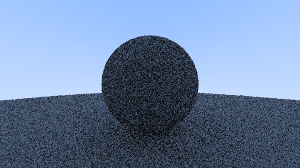

main took 40.6622 seconds to execute.


In [31]:
main()

### 9.2. Limiting the Number of Child Rays

In [32]:
class Camera:
    def __init__(self,
                 aspect_ratio=1.0,
                 image_width=100,
                 samples_per_pixel = 10,
                 max_depth = 10) -> None:

        # public
        self.aspect_ratio = aspect_ratio  # Ratio of image width over height
        self.image_width = image_width  # Rendered image width in pixel count
        self.samples_per_pixel = samples_per_pixel   # Count of random samples for each pixel
        self.max_depth = max_depth   # Maximum number of ray bounces into scene
        
    def render(self, world:HittableList):
        self.initialize()
        
        image_array = []

        for j in tqdm(range(self.image_height)):
            image_rows = []
            for i in range(self.image_width):
                pixel_color = Color(0,0,0)
                for _ in range(self.samples_per_pixel):
                    r:Ray = self.get_ray(i, j)
                    pixel_color += self.ray_color(r, self.max_depth, world)
                
                image_color: Color = write_color(pixel_color, self.samples_per_pixel)
                image_rows.append(image_color.to_tuple())
            image_array.append(image_rows)
        
        im = Image.fromarray(np.uint8(image_array))
        im.show()
        im.save("render.png", "PNG")
        

    def initialize(self):
        self.image_height = int(self.image_width / self.aspect_ratio)
        self.image_height = 1 if (self.image_height < 1) else self.image_height
        
        self.camera_center = Point3(0, 0, 0)

        # Camera
        focal_length = 1.0
        viewport_height = 2.0
        viewport_width = viewport_height * (float(self.image_width)/self.image_height)
        self.camera_center = Point3(0, 0, 0)

        # Calculate the vectors across the horizontal and down the vertical viewport edges.
        viewport_u = Vec3(viewport_width, 0, 0)
        viewport_v = Vec3(0, -viewport_height, 0)

        # Calculate the horizontal and vertical delta vectors from pixel to pixel.
        self.pixel_delta_u = viewport_u / self.image_width
        self.pixel_delta_v = viewport_v / self.image_height

        # Calculate the location of the upper left pixel.
        viewport_upper_left = self.camera_center - Vec3(0, 0, focal_length) - viewport_u/2 - viewport_v/2
        self.pixel00_loc = viewport_upper_left + 0.5 * (self.pixel_delta_u + self.pixel_delta_v)


    # 采样像素(i,j)中的一条光线
    def get_ray(self, i: int, j: int) -> Ray:
        # Get a randomly sampled camera ray for the pixel at location i,j.
        pixel_center = self.pixel00_loc + (i * self.pixel_delta_u) + (j * self.pixel_delta_v)
        pixel_sample = pixel_center + self.pixel_sample_square()

        ray_origin = self.camera_center
        ray_direction = pixel_sample - ray_origin

        return Ray(ray_origin, ray_direction)

    def pixel_sample_square(self) -> Vec3:
        # Returns a random point in the square surrounding a pixel at the origin.
        px = -0.5 + my_random()  # a random real in [0,1).
        py = -0.5 + my_random()  # a random real in [0,1).
        return (px * self.pixel_delta_u) + (py * self.pixel_delta_v)
    
    def ray_color(self, r: Ray, depth:int, world: Hittable) -> Color:
        # If we've exceeded the ray bounce limit, no more light is gathered.
        if depth <= 0:
            return Color(0,0,0)
            
        hit, rec = world.hit(r, Interval(0, INF))
        if hit:
            direction:Vec3 = random_on_hemisphere(rec.normal)
            return 0.5 * self.ray_color(Ray(rec.p, direction), depth-1, world) # 改进递归深度
        
        unit_direction:Vec3 = unit_vector(r.direction())
        a = 0.5*(unit_direction.y + 1.0)
        return (1.0-a)*Color(1.0, 1.0, 1.0) + a*Color(0.5, 0.7, 1.0)

100%|██████████| 168/168 [00:34<00:00,  4.93it/s]


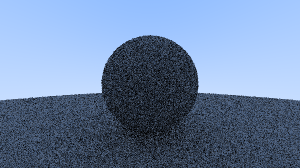

main took 34.1034 seconds to execute.


In [33]:
@timing
def main():
    # World
    world = HittableList()

    world.add(Sphere(Point3(0,0,-1), 0.5))
    world.add(Sphere(Point3(0,-100.5,-1), 100))

    aspect_ratio = 16.0 / 9.0
    image_width = 300
    samples_per_pixel = 5
    max_depth = 10
    
    camera = Camera(aspect_ratio=aspect_ratio,
                 image_width=image_width,
                 samples_per_pixel=samples_per_pixel,
                 max_depth=max_depth)

    camera.render(world=world)
    
main()

### 9.3. Fixing Shadow Acne

In [34]:
class Camera:
    def __init__(self,
                 aspect_ratio=1.0,
                 image_width=100,
                 samples_per_pixel = 10,
                 max_depth = 10) -> None:

        # public
        self.aspect_ratio = aspect_ratio  # Ratio of image width over height
        self.image_width = image_width  # Rendered image width in pixel count
        self.samples_per_pixel = samples_per_pixel   # Count of random samples for each pixel
        self.max_depth = max_depth   # Maximum number of ray bounces into scene
        
    def render(self, world:HittableList):
        self.initialize()
        
        image_array = []

        for j in tqdm(range(self.image_height)):
            image_rows = []
            for i in range(self.image_width):
                pixel_color = Color(0,0,0)
                for _ in range(self.samples_per_pixel):
                    r:Ray = self.get_ray(i, j)
                    pixel_color += self.ray_color(r, self.max_depth, world)
                
                image_color: Color = write_color(pixel_color, self.samples_per_pixel)
                image_rows.append(image_color.to_tuple())
            image_array.append(image_rows)
        
        im = Image.fromarray(np.uint8(image_array))
        im.show()
        im.save("render.png", "PNG")
        

    def initialize(self):
        self.image_height = int(self.image_width / self.aspect_ratio)
        self.image_height = 1 if (self.image_height < 1) else self.image_height
        
        self.camera_center = Point3(0, 0, 0)

        # Camera
        focal_length = 1.0
        viewport_height = 2.0
        viewport_width = viewport_height * (float(self.image_width)/self.image_height)
        self.camera_center = Point3(0, 0, 0)

        # Calculate the vectors across the horizontal and down the vertical viewport edges.
        viewport_u = Vec3(viewport_width, 0, 0)
        viewport_v = Vec3(0, -viewport_height, 0)

        # Calculate the horizontal and vertical delta vectors from pixel to pixel.
        self.pixel_delta_u = viewport_u / self.image_width
        self.pixel_delta_v = viewport_v / self.image_height

        # Calculate the location of the upper left pixel.
        viewport_upper_left = self.camera_center - Vec3(0, 0, focal_length) - viewport_u/2 - viewport_v/2
        self.pixel00_loc = viewport_upper_left + 0.5 * (self.pixel_delta_u + self.pixel_delta_v)


    # 采样像素(i,j)中的一条光线
    def get_ray(self, i: int, j: int) -> Ray:
        # Get a randomly sampled camera ray for the pixel at location i,j.
        pixel_center = self.pixel00_loc + (i * self.pixel_delta_u) + (j * self.pixel_delta_v)
        pixel_sample = pixel_center + self.pixel_sample_square()

        ray_origin = self.camera_center
        ray_direction = pixel_sample - ray_origin

        return Ray(ray_origin, ray_direction)

    def pixel_sample_square(self) -> Vec3:
        # Returns a random point in the square surrounding a pixel at the origin.
        px = -0.5 + my_random()  # a random real in [0,1).
        py = -0.5 + my_random()  # a random real in [0,1).
        return (px * self.pixel_delta_u) + (py * self.pixel_delta_v)
    
    def ray_color(self, r: Ray, depth:int, world: Hittable) -> Color:
        # If we've exceeded the ray bounce limit, no more light is gathered.
        if depth <= 0:
            return Color(0,0,0)
            
        hit, rec = world.hit(r, Interval(0.001, INF))
        if hit:
            direction:Vec3 = random_on_hemisphere(rec.normal)
            return 0.5 * self.ray_color(Ray(rec.p, direction), depth-1, world) # 改进递归深度
        
        unit_direction:Vec3 = unit_vector(r.direction())
        a = 0.5*(unit_direction.y + 1.0)
        return (1.0-a)*Color(1.0, 1.0, 1.0) + a*Color(0.5, 0.7, 1.0)

100%|██████████| 168/168 [00:22<00:00,  7.43it/s]


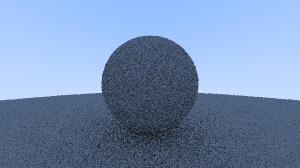

main took 22.6529 seconds to execute.


In [35]:
main()

### 9.4. True Lambertian Reflection

In [36]:
class Camera:
    def __init__(self,
                 aspect_ratio=1.0,
                 image_width=100,
                 samples_per_pixel = 10,
                 max_depth = 10) -> None:

        # public
        self.aspect_ratio = aspect_ratio  # Ratio of image width over height
        self.image_width = image_width  # Rendered image width in pixel count
        self.samples_per_pixel = samples_per_pixel   # Count of random samples for each pixel
        self.max_depth = max_depth   # Maximum number of ray bounces into scene
        
    def render(self, world:HittableList):
        self.initialize()
        
        image_array = []

        for j in tqdm(range(self.image_height)):
            image_rows = []
            for i in range(self.image_width):
                pixel_color = Color(0,0,0)
                for _ in range(self.samples_per_pixel):
                    r:Ray = self.get_ray(i, j)
                    pixel_color += self.ray_color(r, self.max_depth, world)
                
                image_color: Color = write_color(pixel_color, self.samples_per_pixel)
                image_rows.append(image_color.to_tuple())
            image_array.append(image_rows)
        
        im = Image.fromarray(np.uint8(image_array))
        im.show()
        im.save("render.png", "PNG")
        

    def initialize(self):
        self.image_height = int(self.image_width / self.aspect_ratio)
        self.image_height = 1 if (self.image_height < 1) else self.image_height
        
        self.camera_center = Point3(0, 0, 0)

        # Camera
        focal_length = 1.0
        viewport_height = 2.0
        viewport_width = viewport_height * (float(self.image_width)/self.image_height)
        self.camera_center = Point3(0, 0, 0)

        # Calculate the vectors across the horizontal and down the vertical viewport edges.
        viewport_u = Vec3(viewport_width, 0, 0)
        viewport_v = Vec3(0, -viewport_height, 0)

        # Calculate the horizontal and vertical delta vectors from pixel to pixel.
        self.pixel_delta_u = viewport_u / self.image_width
        self.pixel_delta_v = viewport_v / self.image_height

        # Calculate the location of the upper left pixel.
        viewport_upper_left = self.camera_center - Vec3(0, 0, focal_length) - viewport_u/2 - viewport_v/2
        self.pixel00_loc = viewport_upper_left + 0.5 * (self.pixel_delta_u + self.pixel_delta_v)


    # 采样像素(i,j)中的一条光线
    def get_ray(self, i: int, j: int) -> Ray:
        # Get a randomly sampled camera ray for the pixel at location i,j.
        pixel_center = self.pixel00_loc + (i * self.pixel_delta_u) + (j * self.pixel_delta_v)
        pixel_sample = pixel_center + self.pixel_sample_square()

        ray_origin = self.camera_center
        ray_direction = pixel_sample - ray_origin

        return Ray(ray_origin, ray_direction)

    def pixel_sample_square(self) -> Vec3:
        # Returns a random point in the square surrounding a pixel at the origin.
        px = -0.5 + my_random()  # a random real in [0,1).
        py = -0.5 + my_random()  # a random real in [0,1).
        return (px * self.pixel_delta_u) + (py * self.pixel_delta_v)
    
    def ray_color(self, r: Ray, depth:int, world: Hittable) -> Color:
        # If we've exceeded the ray bounce limit, no more light is gathered.
        if depth <= 0:
            return Color(0,0,0)
            
        hit, rec = world.hit(r, Interval(0.001, INF))
        if hit:
            direction:Vec3 = rec.normal + random_unit_vector()
            return 0.5 * self.ray_color(Ray(rec.p, direction), depth-1, world)
        
        unit_direction:Vec3 = unit_vector(r.direction())
        a = 0.5*(unit_direction.y + 1.0)
        return (1.0-a)*Color(1.0, 1.0, 1.0) + a*Color(0.5, 0.7, 1.0)

100%|██████████| 168/168 [00:20<00:00,  8.06it/s]


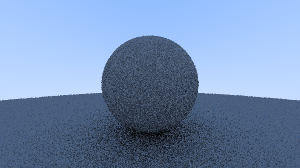

main took 20.8857 seconds to execute.


In [37]:
main()

### 9.5. Using Gamma Correction for Accurate Color Intensity

In [38]:
class Camera:
    def __init__(self,
                 aspect_ratio=1.0,
                 image_width=100,
                 samples_per_pixel = 10,
                 max_depth = 10) -> None:

        # public
        self.aspect_ratio = aspect_ratio  # Ratio of image width over height
        self.image_width = image_width  # Rendered image width in pixel count
        self.samples_per_pixel = samples_per_pixel   # Count of random samples for each pixel
        self.max_depth = max_depth   # Maximum number of ray bounces into scene
        
    def render(self, world:HittableList):
        self.initialize()
        
        image_array = []

        for j in tqdm(range(self.image_height)):
            image_rows = []
            for i in range(self.image_width):
                pixel_color = Color(0,0,0)
                for _ in range(self.samples_per_pixel):
                    r:Ray = self.get_ray(i, j)
                    pixel_color += self.ray_color(r, self.max_depth, world)
                
                image_color: Color = write_color(pixel_color, self.samples_per_pixel)
                image_rows.append(image_color.to_tuple())
            image_array.append(image_rows)
        
        im = Image.fromarray(np.uint8(image_array))
        im.show()
        im.save("render.png", "PNG")
        

    def initialize(self):
        self.image_height = int(self.image_width / self.aspect_ratio)
        self.image_height = 1 if (self.image_height < 1) else self.image_height
        
        self.camera_center = Point3(0, 0, 0)

        # Camera
        focal_length = 1.0
        viewport_height = 2.0
        viewport_width = viewport_height * (float(self.image_width)/self.image_height)
        self.camera_center = Point3(0, 0, 0)

        # Calculate the vectors across the horizontal and down the vertical viewport edges.
        viewport_u = Vec3(viewport_width, 0, 0)
        viewport_v = Vec3(0, -viewport_height, 0)

        # Calculate the horizontal and vertical delta vectors from pixel to pixel.
        self.pixel_delta_u = viewport_u / self.image_width
        self.pixel_delta_v = viewport_v / self.image_height

        # Calculate the location of the upper left pixel.
        viewport_upper_left = self.camera_center - Vec3(0, 0, focal_length) - viewport_u/2 - viewport_v/2
        self.pixel00_loc = viewport_upper_left + 0.5 * (self.pixel_delta_u + self.pixel_delta_v)


    # 采样像素(i,j)中的一条光线
    def get_ray(self, i: int, j: int) -> Ray:
        # Get a randomly sampled camera ray for the pixel at location i,j.
        pixel_center = self.pixel00_loc + (i * self.pixel_delta_u) + (j * self.pixel_delta_v)
        pixel_sample = pixel_center + self.pixel_sample_square()

        ray_origin = self.camera_center
        ray_direction = pixel_sample - ray_origin

        return Ray(ray_origin, ray_direction)

    def pixel_sample_square(self) -> Vec3:
        # Returns a random point in the square surrounding a pixel at the origin.
        px = -0.5 + my_random()  # a random real in [0,1).
        py = -0.5 + my_random()  # a random real in [0,1).
        return (px * self.pixel_delta_u) + (py * self.pixel_delta_v)
    
    def ray_color(self, r: Ray, depth:int, world: Hittable) -> Color:
        # If we've exceeded the ray bounce limit, no more light is gathered.
        if depth <= 0:
            return Color(0,0,0)
            
        hit, rec = world.hit(r, Interval(0.001, INF))
        if hit:
            direction:Vec3 = rec.normal + random_unit_vector()
            return 0.1 * self.ray_color(Ray(rec.p, direction), depth-1, world) # 更暗
        
        unit_direction:Vec3 = unit_vector(r.direction())
        a = 0.5*(unit_direction.y + 1.0)
        return (1.0-a)*Color(1.0, 1.0, 1.0) + a*Color(0.5, 0.7, 1.0)

100%|██████████| 168/168 [00:22<00:00,  7.60it/s]


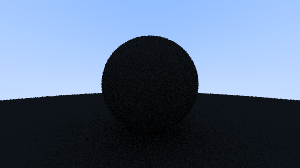

main took 22.1596 seconds to execute.


In [39]:
main()

In [40]:
def intensity():
    return Interval(_min=0.000, _max=0.999)

def linear_to_gamma(linear_component):
    return np.sqrt(linear_component)

def write_color(pixel_color: Color, samples_per_pixel: int):
    scale = 1.0 / samples_per_pixel
    
    return Color(*[int(256 * intensity().clamp(
                                            linear_to_gamma(pixel_color[i] * scale)))
                   for i in range(3)])

100%|██████████| 168/168 [00:22<00:00,  7.61it/s]


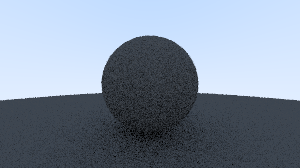

main took 22.1326 seconds to execute.


In [41]:
main() # gamma修正后没那么暗了

## 10. Metal

### 10.1. An Abstract Class for Materials

In [42]:
from collections import namedtuple
ScatterResult = namedtuple('ScatterResult', 'is_scattered, ray, attenuation')

class Material:
    def scatter(self, ray_in: Ray, rec: HitRecord) -> ScatterResult:
        pass

### 10.2. A Data Structure to Describe Ray-Object Intersections

In [43]:
class HitRecord:
    def __init__(self, p, t, material) -> None:
        self.p = p
        self.t = t
        self.material= material

    def set_face_normal(self, ray, outward_normal):
        # Sets the hit record normal vector.
        # NOTE: the parameter `outward_normal` is assumed to have unit length.

        # 视角是否在物体内部
        self.front_face = dot(ray.direction(), outward_normal) < 0  # 向量逆向，dot值为负数 
        self.normal = outward_normal if self.front_face else -outward_normal

In [44]:
class Sphere(Hittable):
    def __init__(self, center, radius, material):
        self.center: Point3 = center
        self.radius: float = radius
        self.material:Material = material 

    def hit(self, ray:Ray, ray_t:Interval) -> Tuple[bool, Optional[HitRecord]]:
        oc: Vec3 = ray.origin() - self.center  # A-C
        a = ray.direction().length_squared()  # b*b
        half_b = dot(oc, ray.direction())  # b*(A-C)
        c = oc.length_squared() - self.radius * self.radius  # (A-C)*(A-C) - r*r

        discriminant = half_b * half_b - a * c  # 二次方程解的判定条件
        if discriminant < 0: return (False, None)
        sqrtd = np.sqrt(discriminant)

        # // Find the nearest root that lies in the acceptable range.
        root = (-half_b - sqrtd) / a
        if not ray_t.surrounds(root):  # root <= ray_t.min or ray_t.max <= root
            root = (-half_b + sqrtd) / a  # 候选较大值
            if not ray_t.surrounds(root):
                return (False, None)

        # 存在合理碰撞，记录碰撞点
        t = root
        p = ray.at(t)
        hit_record = HitRecord(t=t, p=p, material=self.material)
        
        # 判定ray在物体内外，并设置相逆的normal
        outward_normal = (p - self.center) / self.radius
        hit_record.set_face_normal(ray=ray, outward_normal=outward_normal)

        return (True, hit_record)

### 10.3. Modeling Light Scatter and Reflectance

In [45]:
class Lambertian(Material):
    def __init__(self, a) -> None:
        self.albedo: Color = a

    def scatter(self, ray_in: Ray, rec: HitRecord) -> ScatterResult:
        scatter_direction = rec.normal + random_unit_vector()
        scattered = Ray(rec.p, scatter_direction)

        return ScatterResult(is_scattered=True,
                                ray=scattered,
                                attenuation=self.albedo)

In [46]:
from typing import TypeAlias
class Vec3:
    def __init__(self, e0=0, e1=0, e2=0):
        self.e = [float(x) for x in [e0, e1, e2]]

    @property
    def x(self): return self.e[0]
    @property
    def y(self): return self.e[1]
    @property
    def z(self): return self.e[2]
    
    ########################
    # Vec3直接索引
    def __getitem__(self, key):
        return self.e[key]

    def __setitem__(self, key, value):
        self.e[key] = value

    ########################
    # 取值、输出
    def to_tuple(self):
        return tuple(self.e)
    
    def __str__(self):
        return " Vec3 : " + str(tuple(self.e))

    ########################
    # 运算符重载
    def __neg__(self):
        return Vec3(*[-x for x in self.e])
    
    def __add__(self, other):
        if isinstance(other, Vec3):
            return Vec3(*[self[i] + other[i] for i in range(3)])  # vector add
        elif isinstance(other, (int, float)):
            return Vec3(*[self[i] + other for i in range(3)])  # scalar add
        else:
            return NotImplemented  # 表示不支持的类型

    def __radd__(self, other):
        # 当整数在左侧时，调用 __radd__
        return self.__add__(other)

    def __sub__(self, other):
        if isinstance(other, Vec3):
            return Vec3(*[self[i] - other[i] for i in range(3)])
        elif isinstance(other, (int, float)):
            return Vec3(*[self[i] - other for i in range(3)])
        else:
            return NotImplemented  # 表示不支持的类型

    def __mul__(self, other):
        if isinstance(other, Vec3):
            return Vec3(*[self[i] * other[i] for i in range(3)])
        elif isinstance(other, (int, float)):
            return Vec3(*[self[i] * other for i in range(3)])
        else:
            return NotImplemented  # 表示不支持的类型

    def __rmul__(self, other):
        # 当整数在左侧时，调用 __rmul__
        return self.__mul__(other)

    def __truediv__(self, other):
        if isinstance(other, Vec3):
            if other[0] != 0 and other[1] != 0 and other[2] != 0:
                return Vec3(*[self[i] / other[i] for i in range(3)])
            else:
                raise ValueError("Division by vector having zero items")
        elif isinstance(other, (int, float)):
            if other != 0:
                return Vec3(*[self[i] / other for i in range(3)])
            else:
                raise ValueError("Division by zero")
        else:
            return NotImplemented  # 表示不支持的类型

    def __eq__(self, other) -> bool:
        if isinstance(other, Vec3):
            return abs((self - other).length() - 0) < 1e-8
            # return all([self[i] == other[i] for i in range(3)])
        else:
            return False  # 表示不支持的类型
    
    def length(self):
        return np.sqrt(self.length_squared())
     
    def length_squared(self):
        return self.x ** 2 + self.y ** 2 + self.z ** 2
    
    def near_zero(self):
        # Return true if the vector is close to zero in all dimensions.
        epsilon = 1e-8
        return all([abs(self[i]) < epsilon for i in range(3)])

    @staticmethod
    def random(_min=0.0, _max=1.0):
        # 使用静态方法创建类的实例
        return Vec3(my_random(_min, _max), my_random(_min, _max), my_random(_min, _max))

        
Color: TypeAlias = Vec3
Point3: TypeAlias = Vec3

In [47]:
class Lambertian(Material):
    def __init__(self, a) -> None:
        self.albedo: Color = a

    def scatter(self, ray_in: Ray, rec: HitRecord) -> ScatterResult:
        scatter_direction:Vec3 = rec.normal + random_unit_vector()
        
        # Catch degenerate scatter direction
        if scatter_direction.near_zero():
            scatter_direction = rec.normal
            
        scattered = Ray(rec.p, scatter_direction)

        return ScatterResult(is_scattered=True,
                                ray=scattered,
                                attenuation=self.albedo)

### 10.4. Mirrored Light Reflection

In [48]:
def reflect(v: Vec3, n:Vec3)-> Vec3:
    return v - 2*dot(v,n)*n

In [49]:
class Metal(Material):
    def __init__(self, a) -> None:
        self.albedo: Color = a

    def scatter(self, ray_in: Ray, rec: HitRecord) -> ScatterResult:
        reflected = reflect(unit_vector(ray_in.direction()), rec.normal)
        scattered = Ray(rec.p, reflected)

        return ScatterResult(is_scattered=True,
                                ray=scattered,
                                attenuation=self.albedo)


In [50]:
class Camera:
    def __init__(self,
                 aspect_ratio=1.0,
                 image_width=100,
                 samples_per_pixel = 10,
                 max_depth = 10) -> None:

        # public
        self.aspect_ratio = aspect_ratio  # Ratio of image width over height
        self.image_width = image_width  # Rendered image width in pixel count
        self.samples_per_pixel = samples_per_pixel   # Count of random samples for each pixel
        self.max_depth = max_depth   # Maximum number of ray bounces into scene
        
    def render(self, world:HittableList):
        self.initialize()
        
        image_array = []

        for j in tqdm(range(self.image_height)):
            image_rows = []
            for i in range(self.image_width):
                pixel_color = Color(0,0,0)
                for _ in range(self.samples_per_pixel):
                    r:Ray = self.get_ray(i, j)
                    pixel_color += self.ray_color(r, self.max_depth, world)
                
                image_color: Color = write_color(pixel_color, self.samples_per_pixel)
                image_rows.append(image_color.to_tuple())
            image_array.append(image_rows)
        
        im = Image.fromarray(np.uint8(image_array))
        im.show()
        im.save("render.png", "PNG")
        

    def initialize(self):
        self.image_height = int(self.image_width / self.aspect_ratio)
        self.image_height = 1 if (self.image_height < 1) else self.image_height
        
        self.camera_center = Point3(0, 0, 0)

        # Camera
        focal_length = 1.0
        viewport_height = 2.0
        viewport_width = viewport_height * (float(self.image_width)/self.image_height)
        self.camera_center = Point3(0, 0, 0)

        # Calculate the vectors across the horizontal and down the vertical viewport edges.
        viewport_u = Vec3(viewport_width, 0, 0)
        viewport_v = Vec3(0, -viewport_height, 0)

        # Calculate the horizontal and vertical delta vectors from pixel to pixel.
        self.pixel_delta_u = viewport_u / self.image_width
        self.pixel_delta_v = viewport_v / self.image_height

        # Calculate the location of the upper left pixel.
        viewport_upper_left = self.camera_center - Vec3(0, 0, focal_length) - viewport_u/2 - viewport_v/2
        self.pixel00_loc = viewport_upper_left + 0.5 * (self.pixel_delta_u + self.pixel_delta_v)


    # 采样像素(i,j)中的一条光线
    def get_ray(self, i: int, j: int) -> Ray:
        # Get a randomly sampled camera ray for the pixel at location i,j.
        pixel_center = self.pixel00_loc + (i * self.pixel_delta_u) + (j * self.pixel_delta_v)
        pixel_sample = pixel_center + self.pixel_sample_square()

        ray_origin = self.camera_center
        ray_direction = pixel_sample - ray_origin

        return Ray(ray_origin, ray_direction)

    def pixel_sample_square(self) -> Vec3:
        # Returns a random point in the square surrounding a pixel at the origin.
        px = -0.5 + my_random()  # a random real in [0,1).
        py = -0.5 + my_random()  # a random real in [0,1).
        return (px * self.pixel_delta_u) + (py * self.pixel_delta_v)
    
    def ray_color(self, r: Ray, depth:int, world: Hittable) -> Color:
        # If we've exceeded the ray bounce limit, no more light is gathered.
        if depth <= 0:
            return Color(0,0,0)
            
        hit, rec = world.hit(r, Interval(0.001, INF))
        if hit:
            is_scattered, scattered_ray, attenuation = rec.material.scatter(r, rec)
            if is_scattered:
                return attenuation * self.ray_color(scattered_ray, depth-1, world)
            return Color(0,0,0)
        
        unit_direction:Vec3 = unit_vector(r.direction())
        a = 0.5*(unit_direction.y + 1.0)
        return (1.0-a)*Color(1.0, 1.0, 1.0) + a*Color(0.5, 0.7, 1.0)

### 10.5. A Scene with Metal Spheres

100%|██████████| 168/168 [00:44<00:00,  3.81it/s]


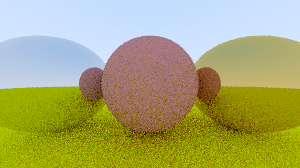

main took 44.1419 seconds to execute.


In [51]:
@timing
def main():
    # World
    world = HittableList()

    material_ground = Lambertian(Color(0.8, 0.8, 0.0))
    material_center = Lambertian(Color(0.7, 0.3, 0.3))
    material_left   = Metal(Color(0.8, 0.8, 0.8))
    material_right  = Metal(Color(0.8, 0.6, 0.2))

    world.add(Sphere(Point3( 0.0, -100.5, -1.0), 100.0, material_ground))
    world.add(Sphere(Point3( 0.0,    0.0, -1.0),   0.5, material_center))
    world.add(Sphere(Point3(-1.0,    0.0, -1.0),   0.5, material_left))
    world.add(Sphere(Point3( 1.0,    0.0, -1.0),   0.5, material_right))

    # camera
    aspect_ratio = 16.0 / 9.0
    image_width = 300
    samples_per_pixel = 5
    max_depth = 10
    
    camera = Camera(aspect_ratio=aspect_ratio,
                 image_width=image_width,
                 samples_per_pixel=samples_per_pixel,
                 max_depth=max_depth)

    camera.render(world=world)
    
main()

### 10.6. Fuzzy Reflection

In [52]:
class Metal(Material):
    def __init__(self, a, f) -> None:
        self.albedo: Color = a
        self.fuzz = f if f < 1 else 1 # 金属的模糊系数 < 1

    def scatter(self, ray_in: Ray, rec: HitRecord) -> ScatterResult:
        reflected = reflect(unit_vector(ray_in.direction()), rec.normal)
        scattered = Ray(rec.p, reflected + + self.fuzz * random_unit_vector())

        # 方向与碰撞点法线同向才反射
        return ScatterResult(is_scattered= dot(scattered.direction(), rec.normal) > 0,
                                ray=scattered,
                                attenuation=self.albedo)

100%|██████████| 168/168 [00:44<00:00,  3.75it/s]


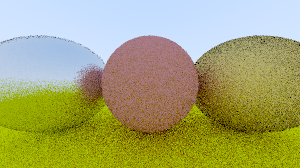

main took 44.9016 seconds to execute.


In [53]:
@timing
def main():
    # World
    world = HittableList()

    material_ground = Lambertian(Color(0.8, 0.8, 0.0))
    material_center = Lambertian(Color(0.7, 0.3, 0.3))
    material_left   = Metal(Color(0.8, 0.8, 0.8), 0.3)
    material_right  = Metal(Color(0.8, 0.6, 0.2), 1.0)

    world.add(Sphere(Point3( 0.0, -100.5, -1.0), 100.0, material_ground))
    world.add(Sphere(Point3( 0.0,    0.0, -1.0),   0.5, material_center))
    world.add(Sphere(Point3(-1.0,    0.0, -1.0),   0.5, material_left))
    world.add(Sphere(Point3( 1.0,    0.0, -1.0),   0.5, material_right))

    # camera
    aspect_ratio = 16.0 / 9.0
    image_width = 300
    samples_per_pixel = 5
    max_depth = 10
    
    camera = Camera(aspect_ratio=aspect_ratio,
                 image_width=image_width,
                 samples_per_pixel=samples_per_pixel,
                 max_depth=max_depth)

    camera.render(world=world)
    
main()

## 11. Dielectrics

In [54]:
def refract(uv: Vec3, n: Vec3, etai_over_etat: float) -> Vec3:
    cos_theta = min(dot(-uv, n), 1.0)
    r_out_perp = etai_over_etat * (uv + cos_theta * n)
    r_out_parallel = -np.sqrt(abs(1.0 - r_out_perp.length_squared())) * n
    return r_out_perp + r_out_parallel

In [55]:
class Dielectric(Material):
    def __init__(self, index_of_refraction):
        self.ir = index_of_refraction  # 折射系数

    def scatter(self, ray_in: Ray, rec: HitRecord) -> ScatterResult:
        refraction_ratio = 1.0 / self.ir if rec.front_face else self.ir  # 根据光线入射方向，决定折射率

        unit_direction = unit_vector(ray_in.direction())
        refracted = refract(unit_direction, rec.normal, refraction_ratio)  # 折射后角度

        return ScatterResult(is_scattered=True,
                                ray=Ray(rec.p, refracted),
                                attenuation=Color(1.0, 1.0, 1.0))  # 没有衰减

100%|██████████| 168/168 [00:49<00:00,  3.42it/s]


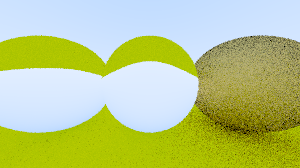

main took 49.4229 seconds to execute.


In [56]:
@timing
def main():
    # World
    world = HittableList()

    material_ground = Lambertian(Color(0.8, 0.8, 0.0))
    material_center =  Dielectric(1.5)
    material_left   = Dielectric(1.5)
    material_right  = Metal(Color(0.8, 0.6, 0.2), 1.0)

    world.add(Sphere(Point3( 0.0, -100.5, -1.0), 100.0, material_ground))
    world.add(Sphere(Point3( 0.0,    0.0, -1.0),   0.5, material_center))
    world.add(Sphere(Point3(-1.0,    0.0, -1.0),   0.5, material_left))
    world.add(Sphere(Point3( 1.0,    0.0, -1.0),   0.5, material_right))

    # camera
    aspect_ratio = 16.0 / 9.0
    image_width = 300
    samples_per_pixel = 5
    max_depth = 10
    
    camera = Camera(aspect_ratio=aspect_ratio,
                 image_width=image_width,
                 samples_per_pixel=samples_per_pixel,
                 max_depth=max_depth)

    camera.render(world=world)
    
main()

### 11.3. Total Internal Reflection

In [57]:
class Dielectric (Material):
    def __init__(self, index_of_refraction):
        self.ir = index_of_refraction # 折射系数

    def scatter(self, ray_in:Ray, rec:HitRecord) -> ScatterResult:
        refraction_ratio = 1.0/self.ir if rec.front_face else self.ir # 根据光线入射方向，决定折射率

        unit_direction = unit_vector(ray_in.direction())

        ## Reflection/refraction choice: calculate both and choose later
        cos_theta = min(dot(-unit_direction,rec.normal), 1.0)
        
        sin_theta = np.sqrt(1.0 - cos_theta**2)
        cannot_refract = refraction_ratio * sin_theta > 1.0

        if cannot_refract:
            direction = reflect(unit_direction, rec.normal) # 反射
        else:
            direction = refract(unit_direction, rec.normal, refraction_ratio) # 折射

        return ScatterResult(is_scattered = True,
                                ray = Ray(rec.p, direction),
                                attenuation = Color(1.0, 1.0, 1.0))
        


100%|██████████| 168/168 [00:47<00:00,  3.51it/s]


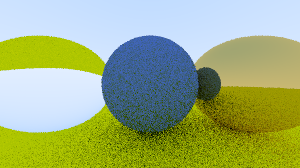

main took 47.9105 seconds to execute.


In [58]:
@timing
def main():
    # World
    world = HittableList()

    material_ground = Lambertian(Color(0.8, 0.8, 0.0))
    material_center = Lambertian(Color(0.1, 0.2, 0.5))
    material_left   = Dielectric(1.5)
    material_right  = Metal(Color(0.8, 0.6, 0.2), 0.0)

    world.add(Sphere(Point3( 0.0, -100.5, -1.0), 100.0, material_ground))
    world.add(Sphere(Point3( 0.0,    0.0, -1.0),   0.5, material_center))
    world.add(Sphere(Point3(-1.0,    0.0, -1.0),   0.5, material_left))
    world.add(Sphere(Point3( 1.0,    0.0, -1.0),   0.5, material_right))

    # camera
    aspect_ratio = 16.0 / 9.0
    image_width = 300
    samples_per_pixel = 5
    max_depth = 10
    
    camera = Camera(aspect_ratio=aspect_ratio,
                 image_width=image_width,
                 samples_per_pixel=samples_per_pixel,
                 max_depth=max_depth)

    camera.render(world=world)
    
main()

### 11.4. Schlick Approximation

In [59]:
class Dielectric (Material):
    def __init__(self, index_of_refraction):
        self.ir = index_of_refraction # 折射系数

    def scatter(self, ray_in:Ray, rec:HitRecord) -> ScatterResult:
        refraction_ratio = 1.0/self.ir if rec.front_face else self.ir # 根据光线入射方向，决定折射率

        unit_direction = unit_vector(ray_in.direction())

        ## Reflection/refraction choice: calculate both and choose later
        cos_theta = min(dot(-unit_direction, rec.normal), 1.0)
        sin_theta = np.sqrt(1.0 - cos_theta**2)
        cannot_refract = refraction_ratio * sin_theta > 1.0

        if cannot_refract or Dielectric.reflectance(cos_theta, refraction_ratio) > my_random():
            direction = reflect(unit_direction, rec.normal) # 反射
        else:
            direction = refract(unit_direction, rec.normal, refraction_ratio) # 折射

        return ScatterResult(is_scattered = True,
                                ray = Ray(rec.p, direction),
                                attenuation = Color(1.0, 1.0, 1.0))
    
    @staticmethod   
    def reflectance(cosine, ref_idx):
        # // Use Schlick's approximation for reflectance.
        r0 = (1 - ref_idx) / (1 + ref_idx)
        r0 = r0 * r0
        return r0 + (1 - r0) * (1 - cosine)**5

### 11.5. Modeling a Hollow Glass Sphere

100%|██████████| 168/168 [01:06<00:00,  2.52it/s]


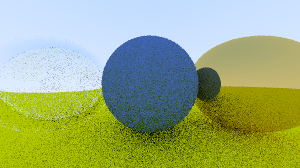

main took 66.8135 seconds to execute.


In [60]:
@timing
def main():
    # World
    world = HittableList()

    material_ground = Lambertian(Color(0.8, 0.8, 0.0))
    material_center = Lambertian(Color(0.1, 0.2, 0.5))
    material_left   = Dielectric(1.5)
    material_right  = Metal(Color(0.8, 0.6, 0.2), 0.0)

    world.add(Sphere(Point3( 0.0, -100.5, -1.0), 100.0, material_ground))
    world.add(Sphere(Point3( 0.0,    0.0, -1.0),   0.5, material_center))
    world.add(Sphere(Point3(-1.0,    0.0, -1.0),   0.5, material_left))
    world.add(Sphere(Point3(-1.0,    0.0, -1.0),  -0.4, material_left))
    world.add(Sphere(Point3( 1.0,    0.0, -1.0),   0.5, material_right))

    # camera
    aspect_ratio = 16.0 / 9.0
    image_width = 300
    samples_per_pixel = 5
    max_depth = 10
    
    camera = Camera(aspect_ratio=aspect_ratio,
                 image_width=image_width,
                 samples_per_pixel=samples_per_pixel,
                 max_depth=max_depth)

    camera.render(world=world)
    
main()

## 12. Positionable Camera

In [61]:
class Camera:
    def __init__(self,
                 aspect_ratio=1.0,
                 image_width=100,
                 samples_per_pixel = 10,
                 max_depth = 10,
                 vfov = 90,
                 ) -> None:

        # public
        self.aspect_ratio = aspect_ratio  # Ratio of image width over height
        self.image_width = image_width  # Rendered image width in pixel count
        self.samples_per_pixel = samples_per_pixel   # Count of random samples for each pixel
        self.max_depth = max_depth   # Maximum number of ray bounces into scene
        self.vfov = vfov   # Vertical view angle (field of view)
        
    def render(self, world:HittableList):
        self.initialize()
        
        image_array = []

        for j in tqdm(range(self.image_height)):
            image_rows = []
            for i in range(self.image_width):
                pixel_color = Color(0,0,0)
                for _ in range(self.samples_per_pixel):
                    r:Ray = self.get_ray(i, j)
                    pixel_color += self.ray_color(r, self.max_depth, world)
                
                image_color: Color = write_color(pixel_color, self.samples_per_pixel)
                image_rows.append(image_color.to_tuple())
            image_array.append(image_rows)
        
        im = Image.fromarray(np.uint8(image_array))
        im.show()
        im.save("render.png", "PNG")
        

    def initialize(self):
        self.image_height = int(self.image_width / self.aspect_ratio)
        self.image_height = 1 if (self.image_height < 1) else self.image_height
        
        self.camera_center = Point3(0, 0, 0)
                
        # Determine viewport dimensions.
        focal_length = 1.0
        theta = degrees_to_radians(self.vfov)
        h = np.tan(theta/2)
        viewport_height = 2 * h * focal_length
        viewport_width = viewport_height * (float(self.image_width)/self.image_height)
        

        # Calculate the vectors across the horizontal and down the vertical viewport edges.
        viewport_u = Vec3(viewport_width, 0, 0)
        viewport_v = Vec3(0, -viewport_height, 0)

        # Calculate the horizontal and vertical delta vectors from pixel to pixel.
        self.pixel_delta_u = viewport_u / self.image_width
        self.pixel_delta_v = viewport_v / self.image_height

        # Calculate the location of the upper left pixel.
        viewport_upper_left = self.camera_center - Vec3(0, 0, focal_length) - viewport_u/2 - viewport_v/2
        self.pixel00_loc = viewport_upper_left + 0.5 * (self.pixel_delta_u + self.pixel_delta_v)


    # 采样像素(i,j)中的一条光线
    def get_ray(self, i: int, j: int) -> Ray:
        # Get a randomly sampled camera ray for the pixel at location i,j.
        pixel_center = self.pixel00_loc + (i * self.pixel_delta_u) + (j * self.pixel_delta_v)
        pixel_sample = pixel_center + self.pixel_sample_square()

        ray_origin = self.camera_center
        ray_direction = pixel_sample - ray_origin

        return Ray(ray_origin, ray_direction)

    def pixel_sample_square(self) -> Vec3:
        # Returns a random point in the square surrounding a pixel at the origin.
        px = -0.5 + my_random()  # a random real in [0,1).
        py = -0.5 + my_random()  # a random real in [0,1).
        return (px * self.pixel_delta_u) + (py * self.pixel_delta_v)
    
    def ray_color(self, r: Ray, depth:int, world: Hittable) -> Color:
        # If we've exceeded the ray bounce limit, no more light is gathered.
        if depth <= 0:
            return Color(0,0,0)
            
        hit, rec = world.hit(r, Interval(0.001, INF))
        if hit:
            is_scattered, scattered_ray, attenuation = rec.material.scatter(r, rec)
            if is_scattered:
                return attenuation * self.ray_color(scattered_ray, depth-1, world)
            return Color(0,0,0)
        
        unit_direction:Vec3 = unit_vector(r.direction())
        a = 0.5*(unit_direction.y + 1.0)
        return (1.0-a)*Color(1.0, 1.0, 1.0) + a*Color(0.5, 0.7, 1.0)

100%|██████████| 168/168 [00:23<00:00,  7.13it/s]


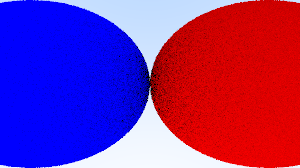

main took 23.6311 seconds to execute.


In [62]:
@timing
def main():
    # World
    world = HittableList()

    R = np.cos(PI/4)

    material_left  = Lambertian(Color(0,0,1))
    material_right = Lambertian(Color(1,0,0))

    world.add(Sphere(Point3(-R, 0, -1), R, material_left))
    world.add(Sphere(Point3( R, 0, -1), R, material_right))

    # camera
    aspect_ratio = 16.0 / 9.0
    image_width = 300
    samples_per_pixel = 5
    max_depth = 10
    vfov = 90 # 垂直可视角度
    
    camera = Camera(aspect_ratio=aspect_ratio,
                 image_width=image_width,
                 samples_per_pixel=samples_per_pixel,
                 max_depth=max_depth,
                 vfov=vfov)

    camera.render(world=world)
    
main()

### 12.2. Positioning and Orienting the Camera

In [63]:
class Camera:
    def __init__(self,
                 aspect_ratio = 1.0,
                 image_width = 100,
                 samples_per_pixel = 10,
                 max_depth = 10,
                 vfov = 90,
                 lookfrom = Point3(0,0,-1),
                 lookat = Point3(0,0,0),
                 vup    = Vec3(0,1,0),
                 ) -> None:

        # public
        self.aspect_ratio = aspect_ratio  # Ratio of image width over height
        self.image_width = image_width  # Rendered image width in pixel count
        self.samples_per_pixel = samples_per_pixel   # Count of random samples for each pixel
        self.max_depth = max_depth   # Maximum number of ray bounces into scene
        self.vfov     = vfov   # Vertical view angle (field of view)
        self.lookfrom = lookfrom  # Point camera is looking from
        self.lookat   = lookat   # Point camera is looking at
        self.vup      = vup     # Camera-relative "up" direction
        
    def render(self, world:HittableList):
        self.initialize()
        
        image_array = []

        for j in tqdm(range(self.image_height)):
            image_rows = []
            for i in range(self.image_width):
                pixel_color = Color(0,0,0)
                for _ in range(self.samples_per_pixel):
                    r:Ray = self.get_ray(i, j)
                    pixel_color += self.ray_color(r, self.max_depth, world)
                
                image_color: Color = write_color(pixel_color, self.samples_per_pixel)
                image_rows.append(image_color.to_tuple())
            image_array.append(image_rows)
        
        im = Image.fromarray(np.uint8(image_array))
        im.show()
        im.save("render.png", "PNG")
        

    def initialize(self):
        self.image_height = int(self.image_width / self.aspect_ratio)
        self.image_height = 1 if (self.image_height < 1) else self.image_height
        
        self.camera_center = self.lookfrom
                
        # Determine viewport dimensions.
        focal_length = (self.lookfrom - self.lookat).length()
        theta = degrees_to_radians(self.vfov)
        h = np.tan(theta/2)
        viewport_height = 2 * h * focal_length
        viewport_width = viewport_height * (float(self.image_width)/self.image_height)
        
        # Calculate the u,v,w unit basis vectors for the camera coordinate frame.
        w = unit_vector(self.lookfrom - self.lookat)
        u = unit_vector(cross(self.vup, w))
        v = cross(w, u)

        # u,v 只是单位向量，乘上系数后变为base坐标
        # Calculate the vectors across the horizontal and down the vertical viewport edges.
        viewport_u = viewport_width * u    # Vector across viewport horizontal edge
        viewport_v = viewport_height * -v  # Vector down viewport vertical edge

        # Calculate the horizontal and vertical delta vectors from pixel to pixel.
        self.pixel_delta_u = viewport_u / self.image_width
        self.pixel_delta_v = viewport_v / self.image_height

        # Calculate the location of the upper left pixel.
        viewport_upper_left = self.camera_center - (focal_length * w) - viewport_u/2 - viewport_v/2
        self.pixel00_loc = viewport_upper_left + 0.5 * (self.pixel_delta_u + self.pixel_delta_v)


    # 采样像素(i,j)中的一条光线
    def get_ray(self, i: int, j: int) -> Ray:
        # Get a randomly sampled camera ray for the pixel at location i,j.
        pixel_center = self.pixel00_loc + (i * self.pixel_delta_u) + (j * self.pixel_delta_v)
        pixel_sample = pixel_center + self.pixel_sample_square()

        ray_origin = self.camera_center
        ray_direction = pixel_sample - ray_origin

        return Ray(ray_origin, ray_direction)

    def pixel_sample_square(self) -> Vec3:
        # Returns a random point in the square surrounding a pixel at the origin.
        px = -0.5 + my_random()  # a random real in [0,1).
        py = -0.5 + my_random()  # a random real in [0,1).
        return (px * self.pixel_delta_u) + (py * self.pixel_delta_v)
    
    def ray_color(self, r: Ray, depth:int, world: Hittable) -> Color:
        # If we've exceeded the ray bounce limit, no more light is gathered.
        if depth <= 0:
            return Color(0,0,0)
            
        hit, rec = world.hit(r, Interval(0.001, INF))
        if hit:
            is_scattered, scattered_ray, attenuation = rec.material.scatter(r, rec)
            if is_scattered:
                return attenuation * self.ray_color(scattered_ray, depth-1, world)
            return Color(0,0,0)
        
        unit_direction:Vec3 = unit_vector(r.direction())
        a = 0.5*(unit_direction.y + 1.0)
        return (1.0-a)*Color(1.0, 1.0, 1.0) + a*Color(0.5, 0.7, 1.0)

100%|██████████| 168/168 [00:31<00:00,  5.26it/s]


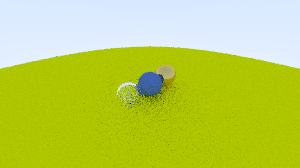

main took 32.0086 seconds to execute.


In [64]:
@timing
def main():
    # World
    world = HittableList()

    material_ground = Lambertian(Color(0.8, 0.8, 0.0))
    material_center = Lambertian(Color(0.1, 0.2, 0.5))
    material_left   = Dielectric(1.5)
    material_right  = Metal(Color(0.8, 0.6, 0.2), 0.0)

    world.add(Sphere(Point3( 0.0, -100.5, -1.0), 100.0, material_ground))
    world.add(Sphere(Point3( 0.0,    0.0, -1.0),   0.5, material_center))
    world.add(Sphere(Point3(-1.0,    0.0, -1.0),   0.5, material_left))
    world.add(Sphere(Point3(-1.0,    0.0, -1.0),  -0.4, material_left))
    world.add(Sphere(Point3( 1.0,    0.0, -1.0),   0.5, material_right))

    # camera
    aspect_ratio = 16.0 / 9.0
    image_width = 300
    samples_per_pixel = 5
    max_depth = 10
    vfov = 90 # 垂直可视角度
    lookfrom = Point3(-2,2,1)
    lookat   = Point3(0,0,-1)
    vup      = Vec3(0,1,0)
    
    camera = Camera(aspect_ratio=aspect_ratio,
                 image_width=image_width,
                 samples_per_pixel=samples_per_pixel,
                 max_depth=max_depth,
                 vfov=vfov,
                 lookfrom=lookfrom,
                 lookat=lookat,
                 vup=vup)

    camera.render(world=world)
    
main()

100%|██████████| 168/168 [01:16<00:00,  2.20it/s]


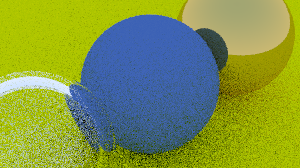

main took 76.4838 seconds to execute.


In [65]:
@timing
def main():
    # World
    world = HittableList()

    material_ground = Lambertian(Color(0.8, 0.8, 0.0))
    material_center = Lambertian(Color(0.1, 0.2, 0.5))
    material_left   = Dielectric(1.5)
    material_right  = Metal(Color(0.8, 0.6, 0.2), 0.0)

    world.add(Sphere(Point3( 0.0, -100.5, -1.0), 100.0, material_ground))
    world.add(Sphere(Point3( 0.0,    0.0, -1.0),   0.5, material_center))
    world.add(Sphere(Point3(-1.0,    0.0, -1.0),   0.5, material_left))
    world.add(Sphere(Point3(-1.0,    0.0, -1.0),  -0.4, material_left))
    world.add(Sphere(Point3( 1.0,    0.0, -1.0),   0.5, material_right))

    # camera
    aspect_ratio = 16.0 / 9.0
    image_width = 300
    samples_per_pixel = 5
    max_depth = 10
    vfov = 20 # 垂直可视角度
    lookfrom = Point3(-2,2,1)
    lookat   = Point3(0,0,-1)
    vup      = Vec3(0,1,0)
    
    camera = Camera(aspect_ratio=aspect_ratio,
                 image_width=image_width,
                 samples_per_pixel=samples_per_pixel,
                 max_depth=max_depth,
                 vfov=vfov,
                 lookfrom=lookfrom,
                 lookat=lookat,
                 vup=vup)

    camera.render(world=world)
    
main()

## 13. Defocus Blur

In [66]:
def random_in_unit_disk() -> Vec3:
    while True:
        p = Vec3(my_random(-1, 1), my_random(-1, 1), 0)
        if p.length_squared() < 1:
            return p


In [67]:
class Camera:
    def __init__(self,
                 aspect_ratio=1.0,
                 image_width=100,
                 samples_per_pixel=10,
                 max_depth=10,
                 vfov=90,
                 lookfrom=Point3(0, 0, -1),
                 lookat=Point3(0, 0, 0),
                 vup=Vec3(0, 1, 0),
                 defocus_angle=0,
                 focus_dist=1
                 ) -> None:

        # public
        self.aspect_ratio = aspect_ratio  # Ratio of image width over height
        self.image_width = image_width  # Rendered image width in pixel count
        self.samples_per_pixel = samples_per_pixel  # Count of random samples for each pixel
        self.max_depth = max_depth  # Maximum number of ray bounces into scene
        self.vfov = vfov  # Vertical view angle (field of view)

        self.lookfrom = lookfrom  # Point camera is looking from
        self.lookat = lookat  # Point camera is looking at
        self.vup = vup  # Camera-relative "up" direction

        self.defocus_angle = defocus_angle  # Variation angle of rays through each pixel
        self.focus_dist = focus_dist  # Distance from camera lookfrom point to plane of perfect focus
        
    def render(self, world:HittableList):
        self.initialize()
        
        image_array = []

        for j in tqdm(range(self.image_height)):
            image_rows = []
            for i in range(self.image_width):
                pixel_color = Color(0,0,0)
                for _ in range(self.samples_per_pixel):
                    r:Ray = self.get_ray(i, j)
                    pixel_color += self.ray_color(r, self.max_depth, world)
                
                image_color: Color = write_color(pixel_color, self.samples_per_pixel)
                image_rows.append(image_color.to_tuple())
            image_array.append(image_rows)
        
        im = Image.fromarray(np.uint8(image_array))
        im.show()
        im.save("render.png", "PNG")

    def initialize(self):

        # Calculate the image height, and ensure that it's at least 1.
        self.image_height = int(self.image_width / self.aspect_ratio)
        self.image_height = 1 if self.image_height < 1 else self.image_height

        self.camera_center = self.lookfrom  # 相机坐标

        # Determine viewport dimensions.
        theta = degrees_to_radians(self.vfov)
        h = np.tan(theta / 2)
        viewport_height = 2 * h * self.focus_dist  # 聚焦平面被放大到外部
        viewport_width = viewport_height * (float(self.image_width) / self.image_height)

        # Calculate the u,v,w unit basis vectors for the camera coordinate frame.
        w = unit_vector((self.lookfrom - self.lookat))
        u = unit_vector(cross(self.vup, w))
        v = cross(w, u)

        # Calculate the vectors across the horizontal and down the vertical viewport edges.
        viewport_u = viewport_width * u  # Vector across viewport horizontal edge
        viewport_v = viewport_height * -v  # Vector down viewport vertical edge

        # Calculate the horizontal and vertical delta vectors from pixel to pixel.
        self.pixel_delta_u = viewport_u / self.image_width
        self.pixel_delta_v = viewport_v / self.image_height

        # Calculate the location of the upper left pixel.
        viewport_upper_left = self.camera_center - (self.focus_dist * w) - viewport_u / 2 - viewport_v / 2
        self.pixel00_loc = viewport_upper_left + 0.5 * (self.pixel_delta_u + self.pixel_delta_v)  # P(0,0)坐标

        # Calculate the camera defocus disk basis vectors.
        defocus_radius = self.focus_dist * np.tan(degrees_to_radians(self.defocus_angle / 2))
        self.defocus_disk_u = u * defocus_radius
        self.defocus_disk_v = v * defocus_radius


    # 采样像素(i,j)中的一条光线
    def get_ray(self, i: int, j: int) -> Ray:
        # Get a randomly-sampled camera ray for the pixel at location i,j, originating from
        # the camera defocus disk.
        pixel_center = self.pixel00_loc + (i * self.pixel_delta_u) + (j * self.pixel_delta_v)
        pixel_sample = pixel_center + self.pixel_sample_square()

        # ray_origin = self.camera_center
        ray_origin = self.camera_center if self.defocus_angle <= 0 else self.defocus_disk_sample()
        ray_direction = pixel_sample - ray_origin

        return Ray(ray_origin, ray_direction)

    def pixel_sample_square(self) -> Vec3:
        # Returns a random point in the square surrounding a pixel at the origin.
        px = -0.5 + my_random()  # a random real in [0,1).
        py = -0.5 + my_random()  # a random real in [0,1).
        return (px * self.pixel_delta_u) + (py * self.pixel_delta_v)

    def defocus_disk_sample(self) -> Point3:
        # Returns a random point in the camera defocus disk.
        p = random_in_unit_disk()
        return self.camera_center + (p.x * self.defocus_disk_u) + (p.y * self.defocus_disk_v)

    def ray_color(self, ray: Ray, depth: int, world: Hittable) -> Color:
        # If we've exceeded the ray bounce limit, no more light is gathered.
        if depth <= 0:
            return Color(0, 0, 0)

        hit, rec = world.hit(ray, Interval(_min=0.001, _max=INF))
        if hit:

            ok, scattered, attenuation = rec.material.scatter(ray, rec)
            if ok:
                # 衰减系数 * 光线反射后看到的全局光照颜色
                return attenuation * self.ray_color(scattered, depth - 1, world)
            # 无折射光线
            return Color(0, 0, 0)

        # 背景
        unit_direction = unit_vector(ray.direction())
        a = 0.5 * (unit_direction.y + 1.0)  # 取值范围在[0.25, 0.75]左右
        return (1.0 - a) * Color(1.0, 1.0, 1.0) + a * Color(0.5, 0.7, 1.0)  # 白色到固定颜色的渐变(线性插值)

100%|██████████| 168/168 [01:18<00:00,  2.14it/s]


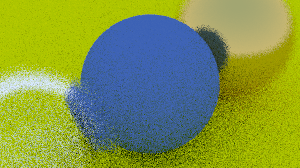

main took 78.6522 seconds to execute.


In [68]:
@timing
def main():
    # World
    world = HittableList()

    material_ground = Lambertian(Color(0.8, 0.8, 0.0))
    material_center = Lambertian(Color(0.1, 0.2, 0.5))
    material_left   = Dielectric(1.5)
    material_right  = Metal(Color(0.8, 0.6, 0.2), 0.0)

    world.add(Sphere(Point3( 0.0, -100.5, -1.0), 100.0, material_ground))
    world.add(Sphere(Point3( 0.0,    0.0, -1.0),   0.5, material_center))
    world.add(Sphere(Point3(-1.0,    0.0, -1.0),   0.5, material_left))
    world.add(Sphere(Point3(-1.0,    0.0, -1.0),  -0.4, material_left))
    world.add(Sphere(Point3( 1.0,    0.0, -1.0),   0.5, material_right))

    # camera
    aspect_ratio = 16.0 / 9.0
    image_width = 300
    samples_per_pixel = 5
    max_depth = 10
    vfov = 20 # 垂直可视角度
    lookfrom = Point3(-2,2,1)
    lookat   = Point3(0,0,-1)
    vup      = Vec3(0,1,0)
    defocus_angle = 10.0
    focus_dist    = 3.4
    
    camera = Camera(aspect_ratio=aspect_ratio,
                 image_width=image_width,
                 samples_per_pixel=samples_per_pixel,
                 max_depth=max_depth,
                 vfov=vfov,
                 lookfrom=lookfrom,
                 lookat=lookat,
                 vup=vup,
                 defocus_angle=defocus_angle,
                 focus_dist=focus_dist)

    camera.render(world=world)
    
main()

## 14. A Final Render

In [69]:
@timing
def main():
    # World
    world = HittableList()

    ground_material = Lambertian(Color(0.5, 0.5, 0.5))
    world.add(Sphere(Point3(0, -1000, 0), 1000, ground_material))

    for a in range(-5, 5):
        for b in range(-5, 5):
            choose_mat = my_random()
            center = Point3(a + 0.9 * my_random(), 0.2, b + 0.9 * my_random())

            if (center - Point3(4, 0.2, 0)).length() > 0.9:
                sphere_material = None

                if choose_mat < 0.8:
                    # diffuse
                    albedo = Color.random() * Color.random()
                    sphere_material = Lambertian(albedo)
                    world.add(Sphere(center, 0.2, sphere_material))
                elif choose_mat < 0.95:
                    # metal
                    albedo = Color.random(0.5, 1)
                    fuzz = my_random(0, 0.5)
                    sphere_material = Metal(albedo, fuzz)
                    world.add(Sphere(center, 0.2, sphere_material))
                else:
                    # glass
                    sphere_material = Dielectric(1.5)
                    world.add(Sphere(center, 0.2, sphere_material))

    # 三个大球
    material1 = Dielectric(1.5)
    world.add(Sphere(Point3(0, 1, 0), 1.0, material1))

    material2 = Lambertian(Color(0.4, 0.2, 0.1))
    world.add(Sphere(Point3(-4, 1, 0), 1.0, material2))

    material3 = Metal(Color(0.7, 0.6, 0.5), 0.0)
    world.add(Sphere(Point3(4, 1, 0), 1.0, material3))

    material_ground = Lambertian(Color(0.8, 0.8, 0.0))
    material_center = Lambertian(Color(0.1, 0.2, 0.5))
    material_left = Dielectric(1.5)
    material_right = Metal(Color(0.8, 0.6, 0.2), 0.0)  # 光滑玻璃

    world.add(Sphere(Point3(0.0, -100.5, -1.0), 100.0, material_ground))
    world.add(Sphere(Point3(0.0, 0.0, -1.0), 0.5, material_center))
    world.add(Sphere(Point3(-1.0, 0.0, -1.0), 0.5, material_left))
    world.add(Sphere(Point3(-1.0, 0.0, -1.0), -0.4, material_left))
    world.add(Sphere(Point3(1.0, 0.0, -1.0), 0.5, material_right))

    # camera
    aspect_ratio = 16.0 / 9.0
    image_width = 400
    samples_per_pixel = 5
    max_depth = 10
    vfov = 20  # 视角90°
    lookfrom = Point3(13, 2, 3)
    lookat = Point3(0, 0, 0)
    vup = Vec3(0, 1, 0)
    defocus_angle = 0.6
    focus_dist = 10

    camera = Camera(aspect_ratio=aspect_ratio,
                    image_width=image_width,
                    samples_per_pixel=samples_per_pixel,
                    max_depth=max_depth,
                    vfov=vfov,
                    lookfrom=lookfrom,
                    lookat=lookat,
                    vup=vup,
                    defocus_angle=defocus_angle,
                    focus_dist=focus_dist,)

    # render
    camera.render(world)
    
# main() 太慢不执行

## 15. Speedup [multiporcess]

In [70]:
import multiprocessing
class Camera:
    def __init__(self,
                 aspect_ratio=1.0,
                 image_width=100,
                 samples_per_pixel=10,
                 max_depth=10,
                 vfov=90,
                 lookfrom=Point3(0, 0, -1),
                 lookat=Point3(0, 0, 0),
                 vup=Vec3(0, 1, 0),
                 defocus_angle=0,
                 focus_dist=1
                 ) -> None:

        # public
        self.aspect_ratio = aspect_ratio  # Ratio of image width over height
        self.image_width = image_width  # Rendered image width in pixel count
        self.samples_per_pixel = samples_per_pixel  # Count of random samples for each pixel
        self.max_depth = max_depth  # Maximum number of ray bounces into scene
        self.vfov = vfov  # Vertical view angle (field of view)

        self.lookfrom = lookfrom  # Point camera is looking from
        self.lookat = lookat  # Point camera is looking at
        self.vup = vup  # Camera-relative "up" direction

        self.defocus_angle = defocus_angle  # Variation angle of rays through each pixel
        self.focus_dist = focus_dist  # Distance from camera lookfrom point to plane of perfect focus
        
    def render_one_pixel(self, params):
        i, j, world = params

        # 计算ray碰撞颜色
        pixel_color = Color(0, 0, 0)
        for _ in range(self.samples_per_pixel):
            ray = self.get_ray(i, j)
            pixel_color += self.ray_color(ray=ray, depth=self.max_depth, world=world)

        # output
        img_rgb_color = write_color(pixel_color, self.samples_per_pixel)
        return img_rgb_color.to_tuple()

    # 多线程render
    def render(self, world: Hittable):
        self.initialize()
        cpu_cores = multiprocessing.cpu_count()

        image_array = [[None] * self.image_width for _ in range(self.image_height)]
        params_list = [(i, j, world) for j in range(self.image_height) for i in range(self.image_width)]

        with multiprocessing.Pool(cpu_cores) as p:
            color_res = p.map(self.render_one_pixel, params_list)
        for idx, (i, j, _) in enumerate(params_list):
            image_array[j][i] = color_res[idx]

        im = Image.fromarray(np.uint8(image_array))
        im.show()
        im.save("render.png", "PNG")

    def initialize(self):
        # Calculate the image height, and ensure that it's at least 1.
        self.image_height = int(self.image_width / self.aspect_ratio)
        self.image_height = 1 if self.image_height < 1 else self.image_height

        self.camera_center = self.lookfrom  # 相机坐标

        # Determine viewport dimensions.
        theta = degrees_to_radians(self.vfov)
        h = np.tan(theta / 2)
        viewport_height = 2 * h * self.focus_dist  # 聚焦平面被放大到外部
        viewport_width = viewport_height * (float(self.image_width) / self.image_height)

        # Calculate the u,v,w unit basis vectors for the camera coordinate frame.
        w = unit_vector((self.lookfrom - self.lookat))
        u = unit_vector(cross(self.vup, w))
        v = cross(w, u)

        # Calculate the vectors across the horizontal and down the vertical viewport edges.
        viewport_u = viewport_width * u  # Vector across viewport horizontal edge
        viewport_v = viewport_height * -v  # Vector down viewport vertical edge

        # Calculate the horizontal and vertical delta vectors from pixel to pixel.
        self.pixel_delta_u = viewport_u / self.image_width
        self.pixel_delta_v = viewport_v / self.image_height

        # Calculate the location of the upper left pixel.
        viewport_upper_left = self.camera_center - (self.focus_dist * w) - viewport_u / 2 - viewport_v / 2
        self.pixel00_loc = viewport_upper_left + 0.5 * (self.pixel_delta_u + self.pixel_delta_v)  # P(0,0)坐标

        # Calculate the camera defocus disk basis vectors.
        defocus_radius = self.focus_dist * np.tan(degrees_to_radians(self.defocus_angle / 2))
        self.defocus_disk_u = u * defocus_radius
        self.defocus_disk_v = v * defocus_radius


    # 采样像素(i,j)中的一条光线
    def get_ray(self, i: int, j: int) -> Ray:
        # Get a randomly-sampled camera ray for the pixel at location i,j, originating from
        # the camera defocus disk.
        pixel_center = self.pixel00_loc + (i * self.pixel_delta_u) + (j * self.pixel_delta_v)
        pixel_sample = pixel_center + self.pixel_sample_square()

        # ray_origin = self.camera_center
        ray_origin = self.camera_center if self.defocus_angle <= 0 else self.defocus_disk_sample()
        ray_direction = pixel_sample - ray_origin

        return Ray(ray_origin, ray_direction)

    def pixel_sample_square(self) -> Vec3:
        # Returns a random point in the square surrounding a pixel at the origin.
        px = -0.5 + my_random()  # a random real in [0,1).
        py = -0.5 + my_random()  # a random real in [0,1).
        return (px * self.pixel_delta_u) + (py * self.pixel_delta_v)

    def defocus_disk_sample(self) -> Point3:
        # Returns a random point in the camera defocus disk.
        p = random_in_unit_disk()
        return self.camera_center + (p.x * self.defocus_disk_u) + (p.y * self.defocus_disk_v)

    def ray_color(self, ray: Ray, depth: int, world: Hittable) -> Color:
        # If we've exceeded the ray bounce limit, no more light is gathered.
        if depth <= 0:
            return Color(0, 0, 0)

        hit, rec = world.hit(ray, Interval(_min=0.001, _max=INF))
        if hit:

            ok, scattered, attenuation = rec.material.scatter(ray, rec)
            if ok:
                # 衰减系数 * 光线反射后看到的全局光照颜色
                return attenuation * self.ray_color(scattered, depth - 1, world)
            # 无折射光线
            return Color(0, 0, 0)

        # 背景
        unit_direction = unit_vector(ray.direction())
        a = 0.5 * (unit_direction.y + 1.0)  # 取值范围在[0.25, 0.75]左右
        return (1.0 - a) * Color(1.0, 1.0, 1.0) + a * Color(0.5, 0.7, 1.0)  # 白色到固定颜色的渐变(线性插值)

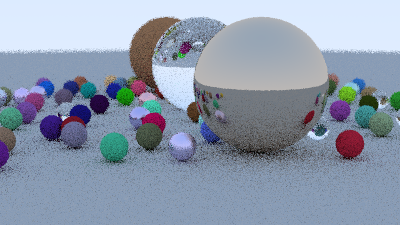

main took 137.4990 seconds to execute.


In [71]:
@timing
def main():
    # World
    world = HittableList()

    ground_material = Lambertian(Color(0.5, 0.5, 0.5))
    world.add(Sphere(Point3(0, -1000, 0), 1000, ground_material))

    for a in range(-5, 5):
        for b in range(-5, 5):
            choose_mat = my_random()
            center = Point3(a + 0.9 * my_random(), 0.2, b + 0.9 * my_random())

            if (center - Point3(4, 0.2, 0)).length() > 0.9:
                sphere_material = None

                if choose_mat < 0.8:
                    # diffuse
                    albedo = Color.random() * Color.random()
                    sphere_material = Lambertian(albedo)
                    world.add(Sphere(center, 0.2, sphere_material))
                elif choose_mat < 0.95:
                    # metal
                    albedo = Color.random(0.5, 1)
                    fuzz = my_random(0, 0.5)
                    sphere_material = Metal(albedo, fuzz)
                    world.add(Sphere(center, 0.2, sphere_material))
                else:
                    # glass
                    sphere_material = Dielectric(1.5)
                    world.add(Sphere(center, 0.2, sphere_material))

    # 三个大球
    material1 = Dielectric(1.5)
    world.add(Sphere(Point3(0, 1, 0), 1.0, material1))

    material2 = Lambertian(Color(0.4, 0.2, 0.1))
    world.add(Sphere(Point3(-4, 1, 0), 1.0, material2))

    material3 = Metal(Color(0.7, 0.6, 0.5), 0.0)
    world.add(Sphere(Point3(4, 1, 0), 1.0, material3))

    material_ground = Lambertian(Color(0.8, 0.8, 0.0))
    material_center = Lambertian(Color(0.1, 0.2, 0.5))
    material_left = Dielectric(1.5)
    material_right = Metal(Color(0.8, 0.6, 0.2), 0.0)  # 光滑玻璃

    world.add(Sphere(Point3(0.0, -100.5, -1.0), 100.0, material_ground))
    world.add(Sphere(Point3(0.0, 0.0, -1.0), 0.5, material_center))
    world.add(Sphere(Point3(-1.0, 0.0, -1.0), 0.5, material_left))
    world.add(Sphere(Point3(-1.0, 0.0, -1.0), -0.4, material_left))
    world.add(Sphere(Point3(1.0, 0.0, -1.0), 0.5, material_right))

    # camera
    aspect_ratio = 16.0 / 9.0
    image_width = 400
    samples_per_pixel = 5
    max_depth = 10
    vfov = 20  # 视角90°
    lookfrom = Point3(13, 2, 3)
    lookat = Point3(0, 0, 0)
    vup = Vec3(0, 1, 0)
    defocus_angle = 0.6
    focus_dist = 10

    camera = Camera(aspect_ratio=aspect_ratio,
                    image_width=image_width,
                    samples_per_pixel=samples_per_pixel,
                    max_depth=max_depth,
                    vfov=vfov,
                    lookfrom=lookfrom,
                    lookat=lookat,
                    vup=vup,
                    defocus_angle=defocus_angle,
                    focus_dist=focus_dist,)

    # render
    camera.render(world)
    
main()